In [1]:
# !pip install catboost
# !pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
# !pip install optuna

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/DACON/중고차 가격 예측/data.zip' -d '/content'

<center><img src=""></center>

<center><h1>중고차 가격 예측 경진대회</h1></center>
<center><h3>데이콘 베이직 Basic | 정형 | NMAE</h3></center>

### 📚 Import Libraries

In [4]:
import os
import gc
import time
import random
import math
import platform
import sklearn
import sys

from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')
matplotlib.rc('figure', figsize=(20,8))

mpl.rcParams['axes.unicode_minus'] = False
# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"

# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
def custom_palette(custom_colors):
    cp = sns.color_palette(custom_colors)
    sns.set_palette(cp)
    sns.palplot(cp, size=0.8)
    plt.tick_params(axis='both', labelsize=0, length=0)

Notebook Color Scheme:


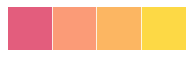

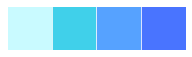

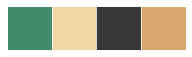

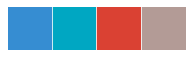

In [5]:
print(clr.S+"Notebook Color Scheme:"+clr.E)

pink = ["#E35D7D", "#FB9B77", "#FCB662", "#FDD945"]
blue = ["#C9FAFF", "#40D0EA", "#56A2FF", "#4974FF"]
my_color1 = ["#448B69", "#F1D7A5", "#373737", "#D8A76C"]
my_color2 = ["#368DD2", "#00A7C2", "#DA4133", "#B39B96"]
custom_palette(pink)
custom_palette(blue)
custom_palette(my_color1)
custom_palette(my_color2)

In [6]:
# 환경 및 버전 확인
print(clr.S + "- os: "+clr.E + f"{platform.platform()}")
print(clr.S + "- python: " + clr.E + f"{sys.version}")
print(clr.S + "- pandas: " + clr.E + f"{pd.__version__}")
print(clr.S + "- numpy: " + clr.E + f"{np.__version__}")
print(clr.S + "- sklearn: " + clr.E + f"{sklearn.__version__}")
# cpu_use = '\033[1m\033[31mCPU\033[0m'
# print(clr.S + "- opencv: " + clr.E + f"{cv2.__version__}")
# print(clr.S + "Setup complete. Using torch " + clr.E + f"{torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else cpu_use})")

- os: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.19.5
- sklearn: 0.23.2


<h2> 📂 Load Data </h2>
<h3> Dataset </h3>
train : 1,015 rows, 11 columns <br>
test : 439 rows 10 columns

***
Columns
```
id : 샘플 아이디
title : 제조사 모델명
odometer : 주행 거리
location : 판매처(나이지리아 도시)
isimported : 현지 사용 여부
engine : 엔진 종류
transmission : 트랜스미션 종류
fuel : 연료 종류
paint : 페인트 색상
year : 제조년도
target : 자동차 가격
```

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
display(train_df.head())
display(test_df.head())

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000


In [8]:
print(clr.S + "train_df.info()"+clr.E)
display(train_df.info())
print(clr.S + "test_df.info()"+clr.E)
display(test_df.info())

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


None

test_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            436 non-null    int64 
 1   title         436 non-null    object
 2   odometer      436 non-null    int64 
 3   location      436 non-null    object
 4   isimported    436 non-null    object
 5   engine        436 non-null    object
 6   transmission  436 non-null    object
 7   fuel          436 non-null    object
 8   paint         436 non-null    object
 9   year          436 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 34.2+ KB


None

결측값 존재하지 않음. 자료형도 적절한 것으로 보임.

## 범주형 자료 살펴보기

In [9]:
cat_cols = train_df.select_dtypes('object')
for col in cat_cols:
    print(clr.S + f"{col.center(30, '=')}"+clr.E)
    display(train_df[col].value_counts())

============title=============


Toyota Camry             129
Toyota Corolla           108
Toyota Highlander         50
Toyota Sienna             49
Toyota RAV 4              40
                        ... 
Scania P94 FLATBED         1
Mercedes-Benz GLA 250      1
Acura ZDX                  1
Iveco TRUCK                1
DAF CF                     1
Name: title, Length: 203, dtype: int64

===========location===========


Lagos          792
Abuja          146
Ogun            26
Lagos           23
Lagos State     16
other            4
FCT              2
Accra            1
Abuja            1
Abia State       1
Adamawa          1
Abia             1
Ogun State       1
Name: location, dtype: int64

==========isimported==========


Foreign Used    744
Locally used    248
New              23
Name: isimported, dtype: int64

============engine============


4-cylinder(I4)    618
6-cylinder(V6)    222
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

=========transmission=========


automatic    965
manual        50
Name: transmission, dtype: int64

=============fuel=============


petrol    970
diesel     45
Name: fuel, dtype: int64

============paint=============


Black          292
White          115
Silver         103
Grey            84
Blue            70
              ... 
WINE             1
Silver/grey      1
Ink blue         1
Light blue       1
Off white l      1
Name: paint, Length: 76, dtype: int64

In [10]:
for col in cat_cols:
    print(clr.S + f"{col.center(30, '=')}"+clr.E)
    display(test_df[col].value_counts())

============title=============


Toyota Corolla           52
Toyota Camry             52
Toyota Highlander        30
Toyota Sienna            29
Toyota RAV 4             19
                         ..
Mercedes-Benz Maybach     1
Acura TSX                 1
Mercedes-Benz GLA 180     1
Volvo S80                 1
Lexus GX 470              1
Name: title, Length: 124, dtype: int64

===========location===========


Lagos                338
Abuja                 68
Lagos                 11
Ogun                   8
Lagos State            5
Mushin                 1
other                  1
Abuja                  1
Arepo ogun state       1
Ogun State             1
Abia                   1
Name: location, dtype: int64

==========isimported==========


Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

============engine============


4-cylinder(I4)      278
6-cylinder(V6)       89
6-cylinder(I6)       44
8-cylinder(V8)       21
5-cylinder(I5)        1
2-cylinder(I2)        1
12-cylinder(V12)      1
3-cylinder(I3)        1
Name: engine, dtype: int64

=========transmission=========


automatic    414
manual        22
Name: transmission, dtype: int64

=============fuel=============


petrol    416
diesel     20
Name: fuel, dtype: int64

============paint=============


Black                      118
Silver                      62
White                       45
Red                         36
Grey                        30
Blue                        27
white                       16
Dark Grey                   14
Gray                        13
Gold                         9
Green                        8
Brown                        5
Black                        4
Dark Blue                    4
Dark Green                   3
Yellow                       3
Blue                         3
green                        3
Ash                          2
Wine                         2
Grey                         2
Sliver                       2
Light Grey                   2
White and green              1
Dark blue                    1
Beige                        1
Classic Silver Met(1F7)      1
Green                        1
Grey and black               1
  Brown                      1
Indigo ink pearl             1
Navy blue                    1
blue    

In [11]:
for col in cat_cols:
    print(clr.S + f"{col.center(30, '=')}"+clr.E)
    print(clr.S + f"train_df만 있는 값"+clr.E)
    print((set(train_df[col].unique()) | set(test_df[col].unique())) - set(test_df[col].unique()))
    print(clr.S + f"test_df만 있는 값"+clr.E)
    print((set(train_df[col].unique()) | set(test_df[col].unique())) - set(train_df[col].unique()))

============title=============
train_df만 있는 값
{'BMW X6', 'Kia Soul', 'Chevrolet Evanda', 'Porsche Macan', 'Peugeot 607', 'Mazda Tribute', 'Dodge Charger', 'Toyota Sequoia', 'Mercedes-Benz GL 450', 'Scania P94 FLATBED', 'Toyota DYNA 200', 'BMW 528', 'MAN-VOLKSWAGEN FLATBED', 'Mercedes-Benz GLA 250', 'Mercedes-Benz E 550', 'Mercedes-Benz GLE 43 AMG', 'Lexus CT 200h', 'Peugeot 308', 'Scania TRACTOR HEAD', 'Mercedes-Benz ATEGO', 'IVM LT35', 'Kia Stinger', 'Nissan X-Trail', 'Hyundai Tucson', 'Land Rover Range Rover Velar', 'Kia Sorento', 'Bentley Arnage', 'Mercedes-Benz ML 320', 'Lexus LS 460', 'Toyota Prado', 'Mack CH613', 'Infiniti QX80', 'Mazda CX-9', 'Isuzu CABSTER', 'Nissan Versa', 'Volkswagen 17.22', 'Man TGA 18.360', 'Toyota Vitz', 'Mercedes-Benz/52', 'Volkswagen Touareg', 'Mercedes-Benz C 63 AMG', 'DAF CF', 'Mack CH613 CONVENTIONAL CAB', 'Kia Cerato', 'Mercedes-Benz C 450 AMG', 'Mazda 6', 'Mercedes-Benz G 63 AMG', 'Mercedes-Benz 450', 'Mitsubishi CANTER PICK UP', 'Mercedes-Benz SL 4

### 제조사, 모델에 따른 가격 차이
- 제조사와 모델명 분리
- Land Rover와 Mercedes-Benz/52 다른 title과는 다르게 작성되어 있어서 따로 처리
- Mercedes-Benz/52는 모델명이 52인지? 해당 모델 검색해봐도 나오지 않음. 이상치로 판단


In [12]:
train_df['title'] = train_df['title'].str.lower()
train_df['manufacturer'] = train_df['title'].str.split(' ', expand=True)[0]    # Manufacturer
train_df.loc[train_df.manufacturer == 'man-volkswagen', 'manufacturer'] = 'man'
train_df.loc[train_df.manufacturer == 'land', 'manufacturer'] = 'land rover'
train_df.loc[train_df.manufacturer == 'mercedes-benz/52', 'manufacturer'] = 'mercedes-benz'

In [13]:
train_df['model_name'] = train_df['title'].apply(lambda x: ' '.join(x.split()[1:]))
train_df.loc[train_df['manufacturer'] == 'land rover', 'model_name'] = train_df.loc[train_df['manufacturer'] == 'land rover', 'title'].str.replace('land rover ', '')

In [14]:
display(train_df['manufacturer'].unique())
train_df['manufacturer'].nunique()

array(['toyota', 'land rover', 'lexus', 'pontiac', 'ford', 'honda',
       'volvo', 'bmw', 'infiniti', 'mercedes-benz', 'hyundai', 'jaguar',
       'mitsubishi', 'nissan', 'mack', 'chevrolet', 'mazda', 'lincoln',
       'kia', 'volkswagen', 'acura', 'daf', 'man', 'isuzu', 'ivm',
       'porsche', 'mini', 'dodge', 'gmc', 'iveco', 'scania', 'gac',
       'peugeot', 'rolls-royce', 'jeep', 'alpina', 'bentley', 'jmc',
       'audi'], dtype=object)

39

In [15]:
test_df['title'] = test_df['title'].str.lower()
test_df['manufacturer'] = test_df['title'].str.split(' ', expand=True)[0]
test_df.loc[test_df.manufacturer == 'man-volkswagen', 'manufacturer'] = 'man'
test_df.loc[test_df.manufacturer == 'land', 'manufacturer'] = 'land rover'
test_df['model_name'] = test_df['title'].apply(lambda x: ' '.join(x.split()[1:]))
test_df.loc[test_df['manufacturer'] == 'land rover', 'model_name'] = test_df.loc[test_df['manufacturer'] == 'land rover', 'title'].str.replace('land rover ', '')
display(test_df['manufacturer'].unique())
test_df['manufacturer'].nunique()

array(['mercedes-benz', 'honda', 'toyota', 'iveco', 'lexus', 'nissan',
       'volkswagen', 'jeep', 'ford', 'bmw', 'mack', 'land rover',
       'hyundai', 'peugeot', 'volvo', 'infiniti', 'acura', 'man', 'fiat',
       'mini', 'daf', 'mazda', 'porsche', 'mitsubishi', 'chevrolet',
       'kia', 'pontiac', 'rolls-royce'], dtype=object)

28

In [16]:
print(clr.S + f"train_df만 있는 값"+clr.E)
print((set(train_df['manufacturer'].unique()) | set(test_df['manufacturer'].unique())) - set(test_df['manufacturer'].unique()))
print(clr.S + f"test_df만 있는 값"+clr.E)
print((set(train_df['manufacturer'].unique()) | set(test_df['manufacturer'].unique())) - set(train_df['manufacturer'].unique()))

train_df만 있는 값
{'scania', 'isuzu', 'gmc', 'bentley', 'dodge', 'jaguar', 'ivm', 'audi', 'alpina', 'gac', 'jmc', 'lincoln'}
test_df만 있는 값
{'fiat'}


In [17]:
test_df[test_df['manufacturer'] == 'fiat']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
158,158,fiat ducato,12488,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Green,2001,fiat,ducato


In [18]:
display(train_df.manufacturer.value_counts().head())
display(train_df.manufacturer.value_counts().tail())

toyota           474
lexus            122
mercedes-benz    106
honda             81
ford              36
Name: manufacturer, dtype: int64

rolls-royce    1
gmc            1
dodge          1
lincoln        1
audi           1
Name: manufacturer, dtype: int64

In [19]:
display(train_df.describe().T)
display(test_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,1015.0,5.070000e+02,2.931496e+02,0.0,253.5,507.0,760.5,1014.0
odometer,1015.0,1.168421e+05,1.051625e+05,0.0,55918.0,94972.0,153224.0,987322.0
year,1015.0,2.008385e+03,3.559212e+01,1217.0,2006.0,2010.0,2014.0,2020.0
target,1015.0,8.243204e+06,1.239567e+07,400000.0,2535000.0,4215000.0,8927500.0,150015008.0


,count,mean,std,min,25%,50%,75%,max
id,436.0,217.500000,126.006614,0.0,108.75,217.5,326.25,435.0
odometer,436.0,116709.064220,137665.801370,0.0,47606.75,89775.5,151271.25,1775588.0
year,436.0,2009.080275,46.582869,1324.0,2006.00,2010.0,2014.00,2626.0


In [20]:
display(train_df.describe(include='object').T)
display(test_df.describe(include='object').T)

,count,unique,top,freq
title,1015,203,toyota camry,129
location,1015,13,Lagos,792
isimported,1015,3,Foreign Used,744
engine,1015,8,4-cylinder(I4),618
transmission,1015,2,automatic,965
fuel,1015,2,petrol,970
paint,1015,76,Black,292
manufacturer,1015,39,toyota,474
model_name,1015,203,camry,129


,count,unique,top,freq
title,436,124,toyota corolla,52
location,436,11,Lagos,338
isimported,436,3,Foreign Used,321
engine,436,8,4-cylinder(I4),278
transmission,436,2,automatic,414
fuel,436,2,petrol,416
paint,436,46,Black,118
manufacturer,436,28,toyota,225
model_name,436,124,corolla,52


## 제조사 별 평균 자동차 가격
😱 Rolls-Royce... 그저 빛

In [21]:
matplotlib.rc('figure', figsize=(20,8))

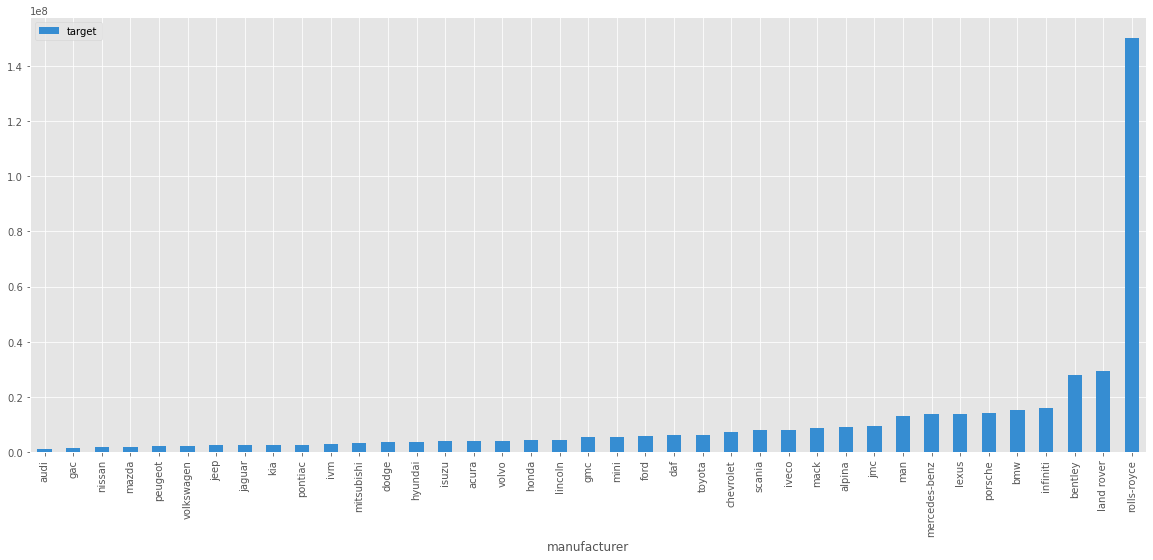

In [22]:
train_df.groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target').set_index('manufacturer').plot(kind='bar');

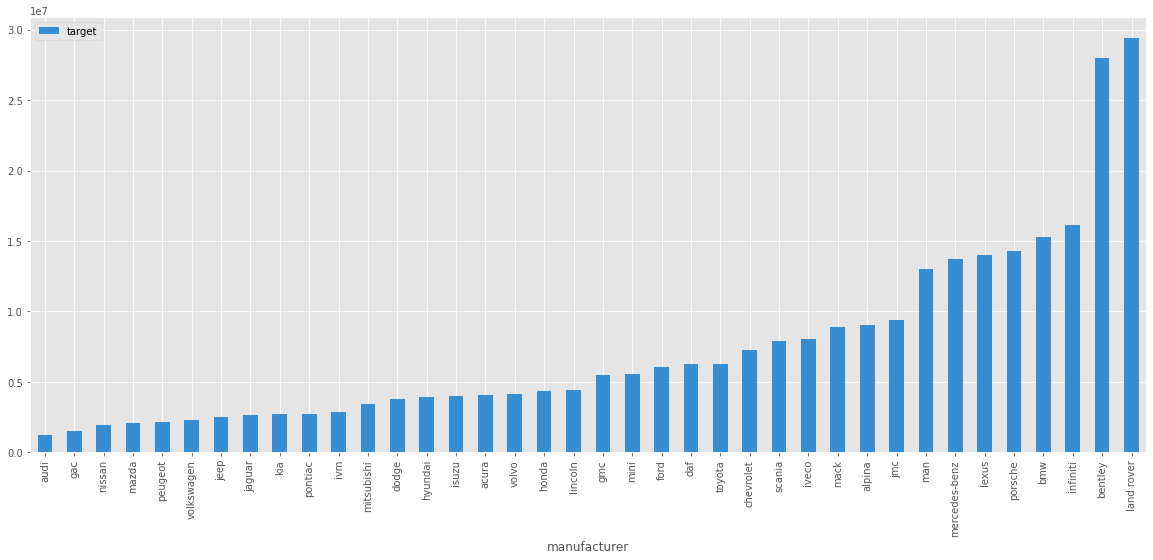

In [23]:
train_df[train_df['manufacturer'] != 'rolls-royce'].groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target').set_index('manufacturer').plot(kind='bar');

## 동일 제조사 모델 별 평균 가격

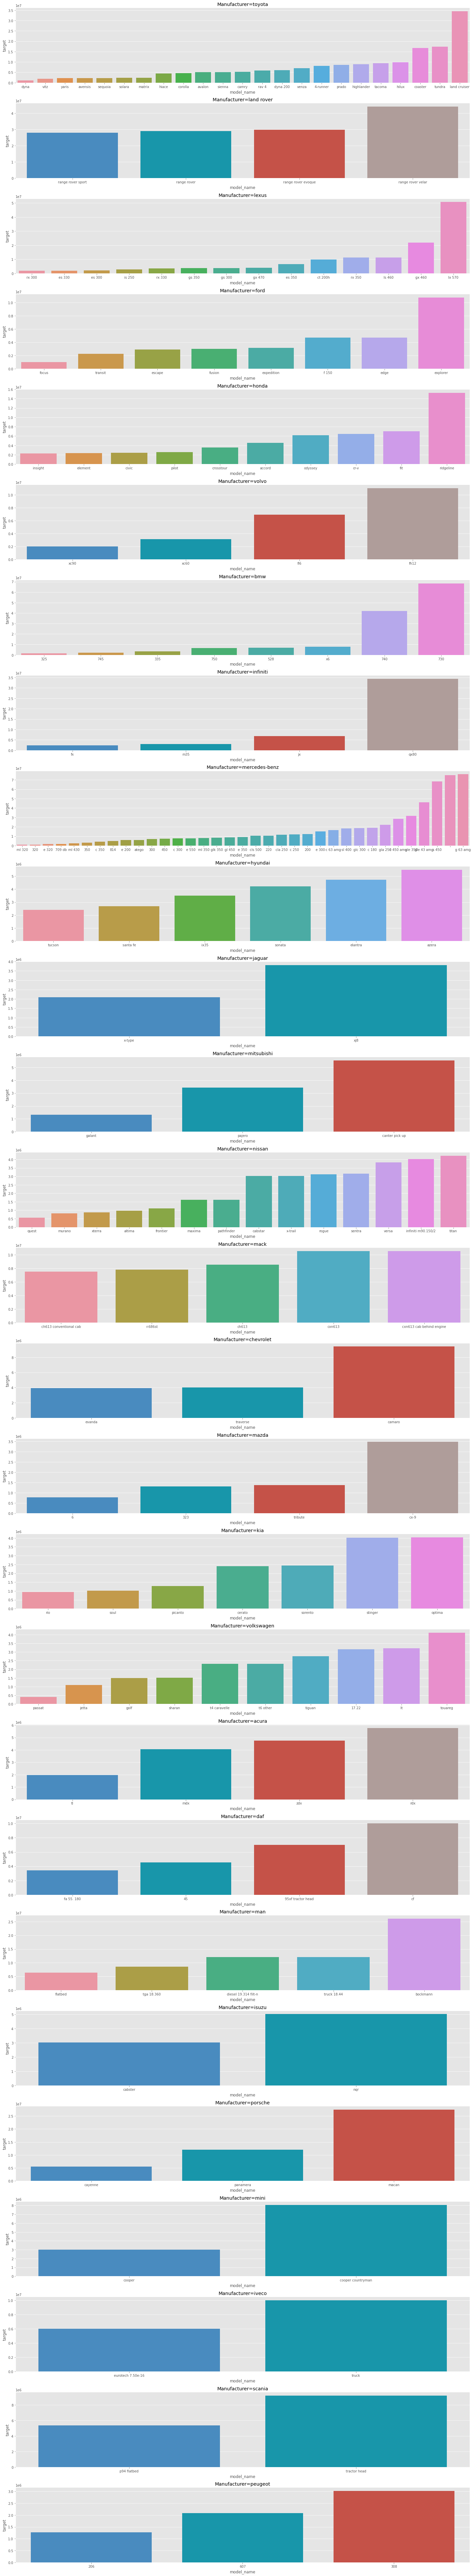

27


In [24]:
n = len(train_df['manufacturer'].unique())
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 4 * n))
count = 0
for manufacturer in train_df['manufacturer'].unique():
    if len(train_df[train_df['manufacturer'] == manufacturer].model_name.unique()) < 2:
        continue
    _data = train_df[train_df['manufacturer'] == manufacturer].groupby('model_name')['target'].mean().reset_index().sort_values(by='target')
    sns.barplot(data=_data, x='model_name', y='target', ax=ax.flat[count])
    ax.flat[count].set(title='Manufacturer=' + manufacturer)
    count += 1
fig.tight_layout()
for i in range(count, n):
    fig.delaxes(ax.flat[i])
plt.show();
print(count)

동일 제조사 모델을 가격대별로 분류하려고 했으나 train에 없는 모델이 많아서 제조사만 쓰기로 함



In [25]:
print(train_df['manufacturer'].unique())
print(test_df['manufacturer'].unique())

['toyota' 'land rover' 'lexus' 'pontiac' 'ford' 'honda' 'volvo' 'bmw'
 'infiniti' 'mercedes-benz' 'hyundai' 'jaguar' 'mitsubishi' 'nissan'
 'mack' 'chevrolet' 'mazda' 'lincoln' 'kia' 'volkswagen' 'acura' 'daf'
 'man' 'isuzu' 'ivm' 'porsche' 'mini' 'dodge' 'gmc' 'iveco' 'scania' 'gac'
 'peugeot' 'rolls-royce' 'jeep' 'alpina' 'bentley' 'jmc' 'audi']
['mercedes-benz' 'honda' 'toyota' 'iveco' 'lexus' 'nissan' 'volkswagen'
 'jeep' 'ford' 'bmw' 'mack' 'land rover' 'hyundai' 'peugeot' 'volvo'
 'infiniti' 'acura' 'man' 'fiat' 'mini' 'daf' 'mazda' 'porsche'
 'mitsubishi' 'chevrolet' 'kia' 'pontiac' 'rolls-royce']


In [26]:
print(clr.S + f"train_df만 있는 값"+clr.E)
print((set(train_df['manufacturer'].unique()) | set(test_df['manufacturer'].unique())) - set(test_df['manufacturer'].unique()))

print(clr.S + f"test_df만 있는 값"+clr.E)
print((set(test_df['manufacturer'].unique()) | set(train_df['manufacturer'].unique())) - set(train_df['manufacturer'].unique()))

train_df만 있는 값
{'scania', 'isuzu', 'gmc', 'bentley', 'dodge', 'jaguar', 'ivm', 'audi', 'alpina', 'gac', 'jmc', 'lincoln'}
test_df만 있는 값
{'fiat'}


In [27]:
print(clr.S + f"train_df만 있는 값"+clr.E)
display((set(train_df['model_name'].unique()) | set(test_df['model_name'].unique())) - set(test_df['model_name'].unique()))

print(clr.S + f"test_df만 있는 값"+clr.E)
display((set(test_df['model_name'].unique()) | set(train_df['model_name'].unique())) - set(train_df['model_name'].unique()))

train_df만 있는 값


{'',
 '17.22',
 '200',
 '308',
 '320',
 '325',
 '335',
 '350',
 '45',
 '450',
 '528',
 '6',
 '607',
 '709 db',
 '730',
 '740',
 '745',
 '750',
 '95xf tractor head',
 'arnage',
 'atego',
 'b3',
 'c 250',
 'c 450 amg',
 'c 63 amg',
 'cabster',
 'canter pick up',
 'cerato',
 'cf',
 'ch613',
 'ch613 conventional cab',
 'charger',
 'cherokee',
 'cla 250',
 'coaster',
 'cooper countryman',
 'ct 200h',
 'cx-9',
 'cxn613',
 'diesel 19.314 filt-n',
 'dyna',
 'dyna 200',
 'e 200',
 'e 320',
 'e 550',
 'es 330',
 'escape',
 'eurotech 7.50e-16',
 'evanda',
 'expedition',
 'fa 55. 180',
 'fh12',
 'flatbed',
 'focus',
 'frontier',
 'g 63 amg',
 'galant',
 'gl 450',
 'gla 250',
 'glc 300',
 'gle 43 amg',
 'gonow other',
 'insight',
 'ix35',
 'jetta',
 'jx',
 'ls 460',
 'lt',
 'lt35',
 'm35',
 'macan',
 'mark',
 'maxima',
 'ml 320',
 'ml 430',
 'murano',
 'nqr',
 'p94 flatbed',
 'panamera',
 'picanto',
 'prado',
 'quest',
 'qx80',
 'range rover evoque',
 'range rover velar',
 'rogue',
 's 450',
 's6',

test_df만 있는 값


{'26-403',
 '307',
 '525',
 '535',
 'a',
 'c 320',
 'c-hr',
 'cabin plus chassis only',
 'cooper coupé',
 'discovery',
 'ducato',
 'dump truck',
 'eclipse',
 'eurocargo 120e18',
 'fl12',
 'fl7',
 'g 550',
 'gla 180',
 'gle 450',
 'glk 300',
 'l200',
 'le 8. 180 platform truck',
 'maybach',
 'mondeo',
 'montero',
 'mustang',
 'primera',
 'prius',
 'rx 400',
 's 550',
 's80',
 'transit pickup',
 'tsx',
 'water tanker',
 'wrangler',
 'x3',
 'xf tractor head'}

### 제조 년도에 따른 평균 가격


왜도 21.650619032991404
첨도 478.3507029697167


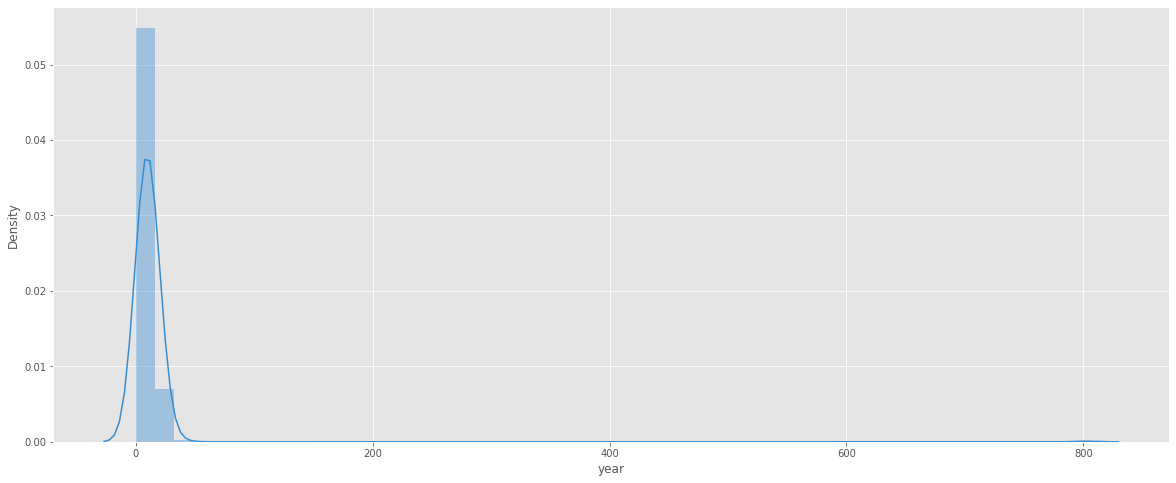

In [28]:
from scipy.stats import skew, kurtosis
print(clr.S + "왜도"+clr.E, skew(2020 - train_df['year']))
print(clr.S + "첨도"+clr.E, kurtosis(2020 - train_df['year']))
sns.distplot(2020 - train_df['year'], kde=True);

In [29]:
display(train_df[train_df['year'] == 1217])
display(train_df[train_df['year'] == 1218])
train_df.loc[train_df['year'] == 1217, 'year'] = np.nan
train_df.loc[train_df['year'] == 1218, 'year'] = np.nan

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name
827,827,mercedes-benz/52,510053,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1217,75015000,mercedes-benz,


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name
415,415,mercedes-benz atego,403461,Lagos,Locally used,4-cylinder(I4),manual,diesel,white,1218,6015000,mercedes-benz,atego


In [30]:
display(test_df[test_df['year'] < 1900])
test_df.loc[test_df['year'] < 1900, 'year'] = np.nan

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
304,304,mercedes-benz cabin plus chassis only,650923,Lagos,Locally used,6-cylinder(V6),manual,diesel,blue,1324,mercedes-benz,cabin plus chassis only
411,411,mercedes-benz water tanker,701934,Lagos,Locally used,8-cylinder(V8),manual,diesel,white,1726,mercedes-benz,water tanker


In [31]:
display(test_df[test_df['year'] > 2020])
test_df.loc[test_df['year'] > 2020, 'year'] = np.nan

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
406,406,mercedes-benz dump truck,0,Lagos,Locally used,8-cylinder(V8),manual,diesel,white,2626.0,mercedes-benz,dump truck


테스트데이터에도 이상치가 있기 때문에 삭제보다는 채워넣는 방법을 생각하는게 좋을 것 같다.

### Location에 따른 가격
train, test 모두 대부분 lagos에 속함 <br>
같은 지역이 다르게 표기되어있는 데이터가 많아서 변경필요<br>
FCT는 아부자의 연방 수도<br>
Mushin도 라고스에 속함 <br>


In [32]:
train_df['location'].value_counts()

Lagos          792
Abuja          146
Ogun            26
Lagos           23
Lagos State     16
other            4
FCT              2
Accra            1
Abuja            1
Abia State       1
Adamawa          1
Abia             1
Ogun State       1
Name: location, dtype: int64

In [33]:
test_df['location'].value_counts()

Lagos                338
Abuja                 68
Lagos                 11
Ogun                   8
Lagos State            5
Mushin                 1
other                  1
Abuja                  1
Arepo ogun state       1
Ogun State             1
Abia                   1
Name: location, dtype: int64

In [34]:
def clean_location(x):
    x = x.lower().strip()
    x = x.replace(' State', '')
    if x in ['mushin', 'lagos']:
        return 'lagos'
    elif x in ['fct', 'abuja']:
        return 'abuja'
    elif x in ['ogun','arepo ogun']:
        return 'ogun'
    else:
        return 'other'

In [35]:
train_df['location'] = train_df['location'].apply(lambda x: clean_location(x))
train_df['location'].value_counts()

lagos    815
abuja    149
ogun      26
other     25
Name: location, dtype: int64

In [36]:
test_df['location'] = test_df['location'].apply(lambda x: clean_location(x))
test_df['location'].value_counts()

lagos    350
abuja     69
other      9
ogun       8
Name: location, dtype: int64

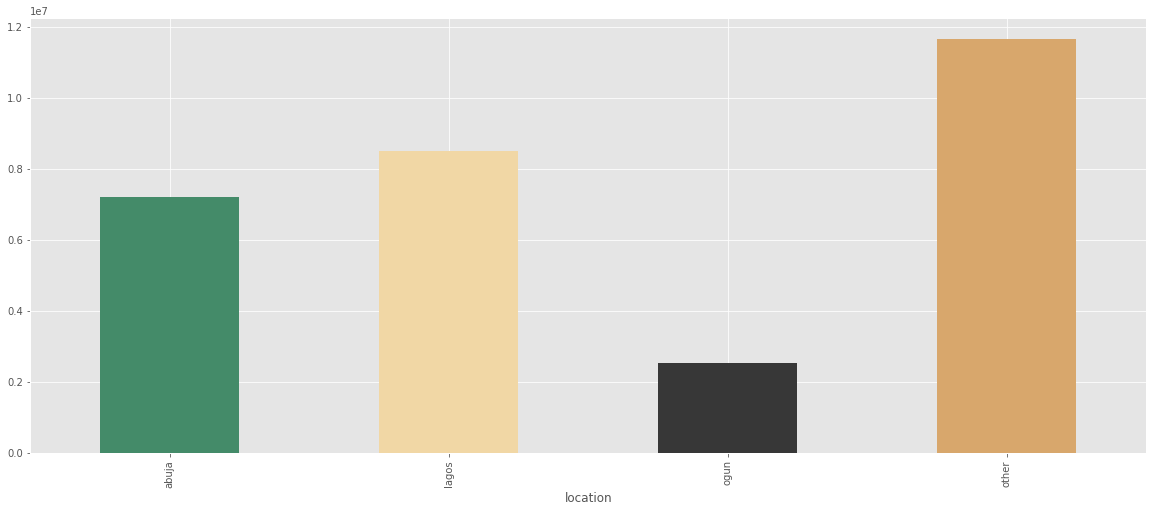

In [37]:
train_df.groupby('location')['target'].mean().plot(kind='bar', color=my_color1+my_color2);

#### Location에 따라 가격차이가 있을까?
일원분산분석 수행

In [38]:
abuja = train_df.loc[train_df['location'] == 'abuja', 'target']
lagos = train_df.loc[train_df['location'] == 'lagos', 'target']
ogun = train_df.loc[train_df['location'] == 'ogun', 'target']
other = train_df.loc[train_df['location'] == 'other', 'target']

In [39]:
from scipy.stats import *
print(clr.S + "각 그룹의 분포가 정규분포를 따르는지 확인" +clr.E)

print(kstest(abuja, 'norm'))
print(kstest(lagos, 'norm'))
print(kstest(ogun, 'norm'))
print(kstest(other, 'norm'))

print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(abuja, lagos, ogun, other))

각 그룹의 분포가 정규분포를 따르는지 확인
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
일원분산분석
F_onewayResult(statistic=2.9469422255023563, pvalue=0.03197379885265679)


In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(clr.S + "p-value 0.05미만으로 차이가 존재하므로 사후분석 수행" +clr.E)
Group = ["abuja"] * len(abuja) + ["lagos"] * len(lagos) + ["ogun"] * len(ogun) + ["other"] * len(other)
Data = abuja.tolist() + lagos.tolist() + ogun.tolist() + other.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value 0.05미만으로 차이가 존재하므로 사후분석 수행


group1,group2,meandiff,p-adj,lower,upper,reject
abuja,lagos,1280797.921,0.6325,-1553106.9624,4114702.8043,False
abuja,ogun,-4688606.8663,0.2814,-11448781.3795,2071567.647,False
abuja,other,4442846.9799,0.3442,-2431479.8597,11317173.8194,False
lagos,ogun,-5969404.7873,0.0733,-12305930.6347,367121.0602,False
lagos,other,3162049.0589,0.5781,-3296121.7242,9620219.8419,False
ogun,other,9131453.8462,0.0421,222081.6783,18040826.014,True


other와 ogun 지역간의 가격차이가 있다고 할 수 있으므로 other와 ogun 파생변수 생성

### 현지 사용 여부에 따른 가격차

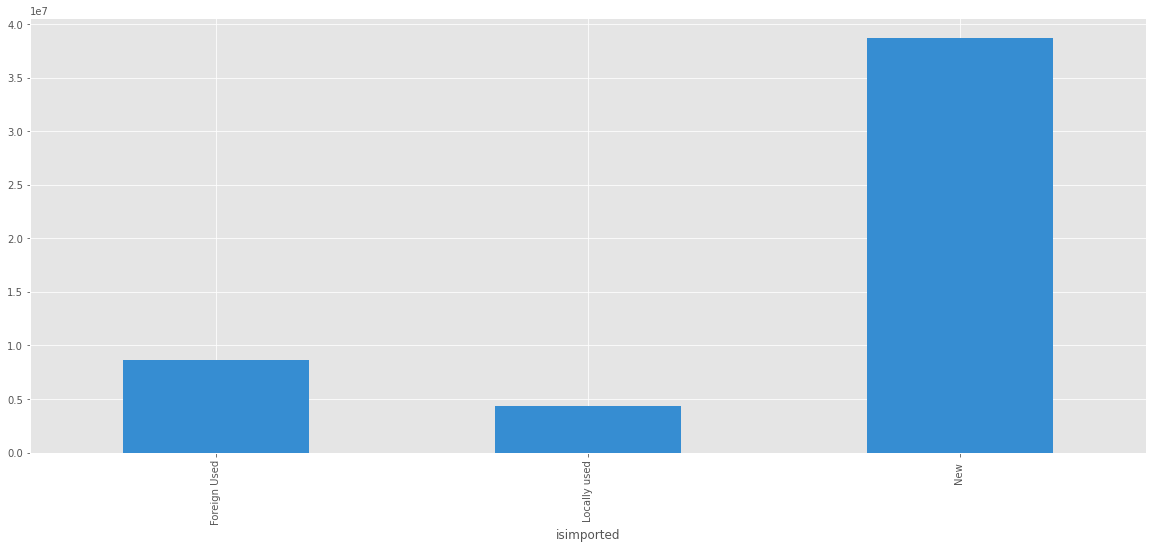

In [41]:
train_df.groupby('isimported')['target'].mean().plot(kind='bar');

In [42]:
train_df['isimported'] = train_df['isimported'].apply(lambda x: x.strip())
train_df[train_df['isimported'] == 'New']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name
1,1,toyota land cruiser,10,lagos,New,4-cylinder(I4),automatic,petrol,Black,2019.0,33015000,toyota,land cruiser
164,164,toyota corolla,101,abuja,New,4-cylinder(I4),automatic,petrol,Dark Grey,2018.0,8215000,toyota,corolla
216,216,mercedes-benz gle 350,693,lagos,New,4-cylinder(I4),automatic,petrol,Blue,2020.0,56515000,mercedes-benz,gle 350
295,295,toyota land cruiser,46,lagos,New,4-cylinder(I4),automatic,petrol,Black,2019.0,37015000,toyota,land cruiser
316,316,honda civic,24997,abuja,New,4-cylinder(I4),automatic,petrol,White,2018.0,8665000,honda,civic
353,353,toyota corolla,21,other,New,6-cylinder(V6),automatic,petrol,Black,2019.0,33015000,toyota,corolla
364,364,toyota land cruiser,81,other,New,6-cylinder(V6),automatic,petrol,Black,2019.0,33040000,toyota,land cruiser
391,391,honda accord,9346,abuja,New,4-cylinder(I4),automatic,petrol,Black,2019.0,10515000,honda,accord
423,423,toyota land cruiser,47,lagos,New,4-cylinder(I4),automatic,petrol,Black,2020.0,65015000,toyota,land cruiser
432,432,bmw 730,467,lagos,New,4-cylinder(I4),automatic,petrol,Black,2020.0,68265000,bmw,730


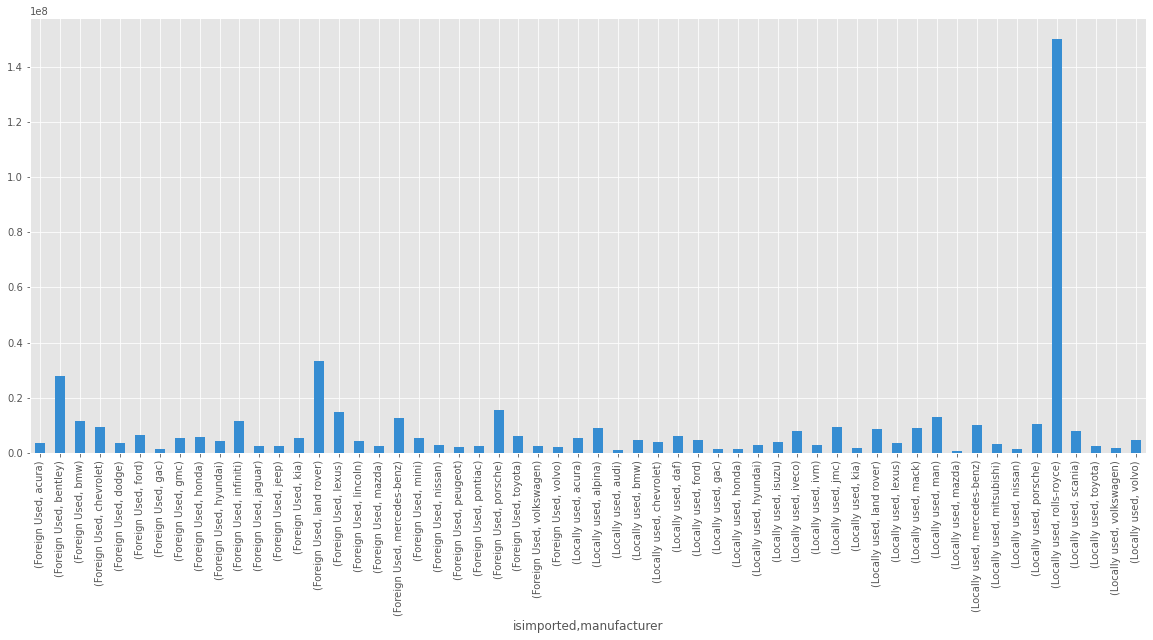

In [43]:
train_df[train_df['isimported'] != 'New'].groupby(['isimported', 'manufacturer'])['target'].mean().plot(kind='bar');

In [44]:
display(train_df['isimported'].value_counts())
display(test_df['isimported'].value_counts())

Foreign Used    744
Locally used    248
New              23
Name: isimported, dtype: int64

Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

In [45]:
print(clr.S + "isimported에 대한 일원분산분석" +clr.E)

foreign = train_df.loc[train_df['isimported'] == 'Foreign Used', 'target']
local = train_df.loc[train_df['isimported'] == 'Locally used', 'target']
new = train_df.loc[train_df['isimported'] == 'New', 'target']

print(clr.S + "각 그룹의 분포가 정규분포를 따르는지 확인" +clr.E)

print(kstest(foreign, 'norm'))
print(kstest(local, 'norm'))
print(kstest(new, 'norm'))

print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(foreign, local, new))

isimported에 대한 일원분산분석
각 그룹의 분포가 정규분포를 따르는지 확인
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
일원분산분석
F_onewayResult(statistic=97.57526881958104, pvalue=1.7785032471137657e-39)


In [46]:
print(clr.S + "p-value가 0에 수렴하므로 유의한 차이 존재" +clr.E)
Group = ["foreign"] * len(foreign) + ["local"] * len(local) + ["new"] * len(new)
Data = foreign.tolist() + local.tolist() + new.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value가 0에 수렴하므로 유의한 차이 존재


group1,group2,meandiff,p-adj,lower,upper,reject
foreign,local,-4288422.6949,0.001,-6243676.2865,-2333169.1033,True
foreign,new,30045914.2294,0.001,24400356.3971,35691472.0617,True
local,new,34334336.9243,0.001,28521950.8788,40146722.9697,True


모든 그룹이 서로 유의한 차이가 있음. 원핫인코딩으로 사용

## engine에 따른 가격 차이
H : Horizontal
V : Vertical
I : Incline 
- ~~차종에 따라 달라지는 중요한 특징이라고 생각해서 따로 분리~~ 분리 후 corr 확인 결과 다중공선성 발생.
- 실린더 개수인 맨 앞 한자리 숫자만 남김



In [47]:
train_df['engine'] = train_df['engine'].apply(lambda x: x.strip())

In [48]:
train_df['cylinder'] = train_df['engine'].str[0].astype(int)
# train_df['engine'] = train_df['engine'].str[-3:-2]

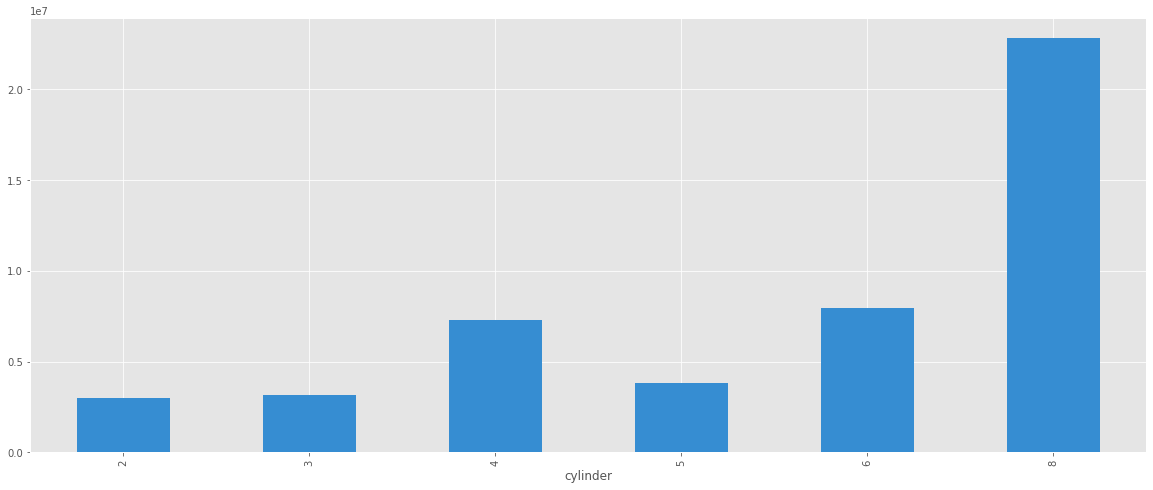

In [49]:
train_df.groupby(['cylinder'])['target'].mean().plot(kind='bar');

In [50]:
pearson_r = pearsonr(train_df['cylinder'], train_df['target'])
print(clr.S + "피어슨 상관계수:" +clr.E + f"{pearson_r[0]}, " + clr.S + " p-value: " + clr.E + f"{pearson_r[1]}")

피어슨 상관계수:0.1801634429795984,  p-value: 7.46447374307969e-09


선형관계가 성립하므로 실린더 수가 많을 수록 가격이 높아진다고 할 수 있다. <br>
실린더 개수를 numeric feature로 사용

In [51]:
test_df[test_df['engine'] == '12-cylinder(V12)']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name
142,142,mercedes-benz maybach,6758,lagos,New,12-cylinder(V12),automatic,petrol,Black,2019.0,mercedes-benz,maybach


In [52]:
test_df['engine'] = test_df['engine'].apply(lambda x: x.strip())
test_df['cylinder'] = (test_df['engine'].str[0]).astype(int)

In [53]:
test_df.loc[test_df['id'] == 142, 'cylinder'] = 12
test_df['cylinder'] = test_df['cylinder'].astype(int)

In [54]:
display(train_df['engine'].value_counts())
display(test_df['engine'].value_counts())
display(train_df['cylinder'].value_counts())
display(test_df['cylinder'].value_counts())

4-cylinder(I4)    618
6-cylinder(V6)    222
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

4-cylinder(I4)      278
6-cylinder(V6)       89
6-cylinder(I6)       44
8-cylinder(V8)       21
5-cylinder(I5)        1
2-cylinder(I2)        1
12-cylinder(V12)      1
3-cylinder(I3)        1
Name: engine, dtype: int64

4    620
6    340
8     49
3      3
5      2
2      1
Name: cylinder, dtype: int64

4     278
6     133
8      21
5       1
2       1
12      1
3       1
Name: cylinder, dtype: int64

#### engine 그룹

In [55]:
train_df['engine_2~3'] = ((train_df['cylinder'] >= 2) & (train_df['cylinder'] < 4)).astype(int)
train_df['engine_4~6'] = ((train_df['cylinder'] >= 4) & (train_df['cylinder'] < 7)).astype(int)
train_df['engine_8~'] = (train_df['cylinder'] >= 8).astype(int)
train_df.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_2~3,engine_4~6,engine_8~
0,0,toyota rav 4,18277,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016.0,13665000,toyota,rav 4,4,0,1,0
1,1,toyota land cruiser,10,lagos,New,4-cylinder(I4),automatic,petrol,Black,2019.0,33015000,toyota,land cruiser,4,0,1,0
2,2,land rover range rover evoque,83091,lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012.0,9915000,land rover,range rover evoque,6,0,1,0
3,3,lexus es 350,91524,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007.0,3815000,lexus,es 350,4,0,1,0
4,4,toyota venza,94177,lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010.0,7385000,toyota,venza,6,0,1,0


In [56]:
test_df['engine_2~3'] = ((test_df['cylinder'] >= 2) & (test_df['cylinder'] < 4)).astype(int)
test_df['engine_4~6'] = ((test_df['cylinder'] >= 4) & (test_df['cylinder'] < 7)).astype(int)
test_df['engine_8~'] = (test_df['cylinder'] >= 8).astype(int)
test_df.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_2~3,engine_4~6,engine_8~
0,0,mercedes-benz c 300,1234,abuja,New,4-cylinder(I4),automatic,petrol,White,2017.0,mercedes-benz,c 300,4,0,1,0
1,1,honda accord,29938,abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013.0,honda,accord,4,0,1,0
2,2,mercedes-benz s 550,87501,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012.0,mercedes-benz,s 550,4,0,1,0
3,3,toyota sienna,180894,lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001.0,toyota,sienna,6,0,1,0
4,4,toyota hiace,104814,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000.0,toyota,hiace,4,0,1,0


In [57]:
engine23 = train_df.loc[(train_df['cylinder'] >= 2) & (train_df['cylinder'] < 4), 'target']
engine456 = train_df.loc[(train_df['cylinder'] >= 4) & (train_df['cylinder'] < 7), 'target']
engine812 = train_df.loc[(train_df['cylinder'] >= 8), 'target']

print(kstest(engine23, 'norm'))
print(kstest(engine456, 'norm'))
print(kstest(engine812, 'norm'))

print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(engine23, engine456, engine812))

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
일원분산분석
F_onewayResult(statistic=38.39163669544376, pvalue=8.491228369693506e-17)


In [58]:
print(clr.S + "p-value가 0에 수렴하므로 유의한 차이 존재" +clr.E)
Group = ["engine23"] * len(engine23) + ["engine456"] * len(engine456) + ["engine812"] * len(engine812)
Data = engine23.tolist() + engine456.tolist() + engine812.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value가 0에 수렴하므로 유의한 차이 존재


group1,group2,meandiff,p-adj,lower,upper,reject
engine23,engine456,4415595.132,0.7223,-9652671.5345,18483861.7985,False
engine23,engine812,19692602.0408,0.0045,5091707.6582,34293496.4234,True
engine456,engine812,15277006.9088,0.001,11164945.7805,19389068.0371,True


8이상일 경우에만 유의한 차이 존재

In [59]:
train_df.drop(['engine_2~3', 'engine_4~6'], axis=1, inplace=True)
test_df.drop(['engine_2~3', 'engine_4~6'], axis=1, inplace=True)

In [60]:
train_df['engine_d'] = train_df['engine'].str[-3:-2]
train_df['engine_d'].value_counts()

I    742
V    271
H      2
Name: engine_d, dtype: int64

In [61]:
test_df['engine_d'] = test_df['engine'].str[-3:-2]
test_df.loc[test_df['id'] == 142, 'engine_d'] = 'V'
test_df['engine_d'].value_counts()

I    325
V    111
Name: engine_d, dtype: int64

In [62]:
engine_I = train_df.loc[(train_df['engine_d'] == 'I'), 'target']
engine_H = train_df.loc[(train_df['engine_d'] == 'H'), 'target']
engine_V = train_df.loc[(train_df['engine_d'] == "V"), 'target']

print(kstest(engine_I, 'norm'))
print(kstest(engine_H, 'norm'))
print(kstest(engine_V, 'norm'))

print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(engine_I, engine_H, engine_V))

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
일원분산분석
F_onewayResult(statistic=7.266718505560134, pvalue=0.000735445806998008)


In [63]:
print(clr.S + "p-value가 0.05 미만으로 유의한 차이 존재" +clr.E)
Group = ["engine_I"] * len(engine_I) + ["engine_H"] * len(engine_H) + ["engine_V"] * len(engine_V)
Data = engine_I.tolist() + engine_H.tolist() + engine_V.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value가 0.05 미만으로 유의한 차이 존재


group1,group2,meandiff,p-adj,lower,upper,reject
engine_H,engine_I,-4040782.3221,0.8788,-24515751.0794,16434186.4352,False
engine_H,engine_V,-722276.7528,0.9,-21245019.9442,19800466.4387,False
engine_I,engine_V,3318505.5693,0.001,1266059.0239,5370952.1148,True


엔진종류와 cylinder간 상관관계가 높아서 cylinder feature만 사용

### 이상치 처리
year 이상치 id : train [827, 415], test [304, 411] <br>

~~1. 동일한 엔진을 가진 자동차들의 평균 year를 넣어주고, 동일한 엔진 가진 자동차들의 연 평균 주행거리 * year로 odometer 결측치 채우기~~
<br>
2. 이상치 제거하기 --> 테스트는 제거할 수 없음..

In [64]:
train_df.loc[train_df['odometer'] == 0, 'odometer'] = np.nan
test_df.loc[test_df['odometer'] == 0, 'odometer'] = np.nan

train_df['odometer_per_year'] = train_df['odometer'] / (2021 - train_df['year'])
test_df['odometer_per_year'] = test_df['odometer'] / (2021 - test_df['year'])

#### 연 평균 주행거리 확인
연 평균 10만이상인 데이터 제거<br>
테스트 데이터의 연 평균 주행거리는 모두 2만 미만.. 넉넉하게 4만이상을 이상치로 생각하고 이상치 제거

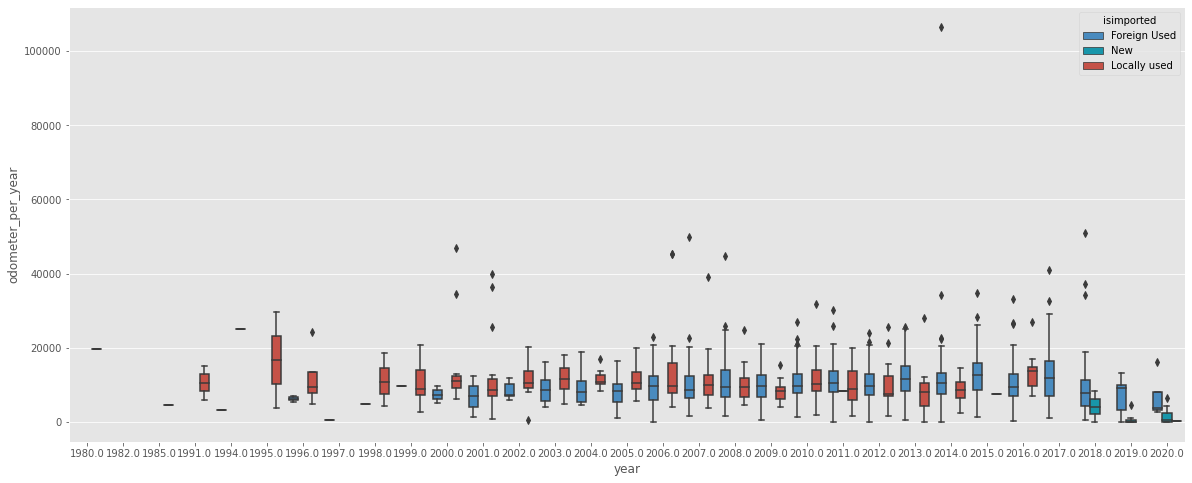

In [65]:
sns.boxplot(data=train_df, x='year', y='odometer_per_year', hue='isimported')
plt.show();

In [66]:
train_df.loc[(train_df['year'] == 2014) & (train_df['odometer'] > 600000)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
46,46,honda accord,745932.0,lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Deep blue,2014.0,5515000,honda,accord,4,0,I,106561.714286


In [67]:
train_df[train_df['isimported'] == 'Locally used'].odometer_per_year.mean()

11539.500962205713

In [68]:
train_df[train_df['isimported'] == 'Foreign Used'].odometer_per_year.mean()

10787.831920535471

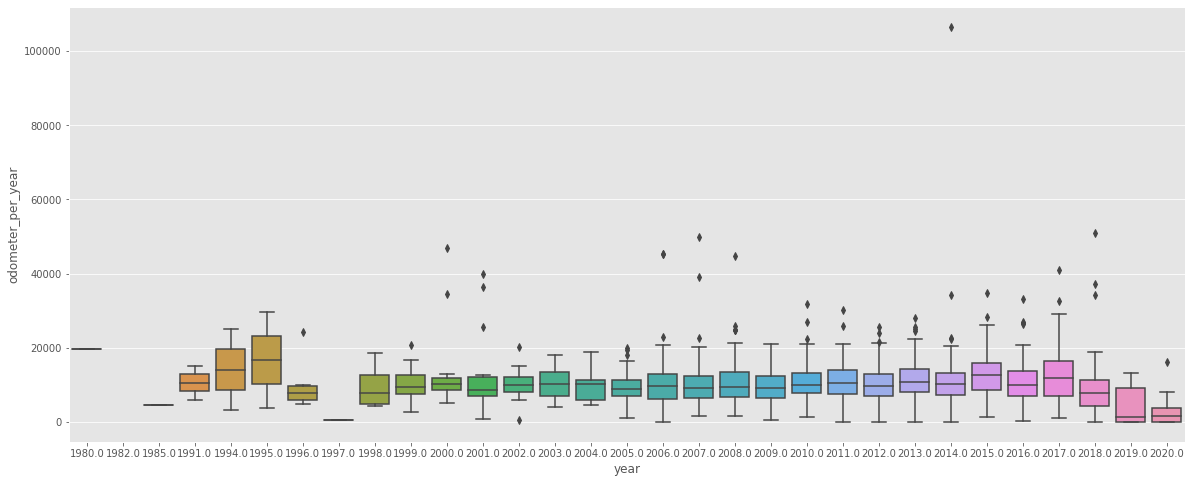

In [69]:
sns.boxplot(data=train_df, x='year', y='odometer_per_year')
plt.show();

In [70]:
test_df['odometer_per_year'].mean()

10649.87590546528

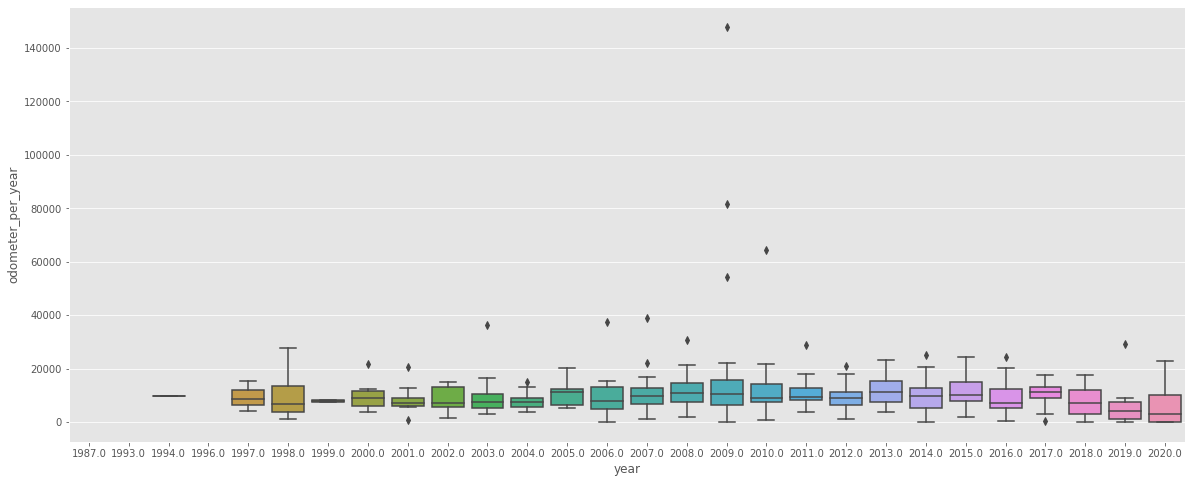

In [71]:
sns.boxplot(data=test_df, x='year', y='odometer_per_year')
plt.show();

In [72]:
display(train_df[train_df['id'] == 415])
display(train_df[train_df['id'] == 827])
display(test_df[test_df['id'] == 304])
display(test_df[test_df['id'] == 406])
display(test_df[test_df['id'] == 411])

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
415,415,mercedes-benz atego,403461.0,lagos,Locally used,4-cylinder(I4),manual,diesel,white,NaN,6015000,mercedes-benz,atego,4,0,I,NaN


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
827,827,mercedes-benz/52,510053.0,lagos,Locally used,6-cylinder(V6),manual,diesel,white,NaN,75015000,mercedes-benz,,6,0,V,NaN


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
304,304,mercedes-benz cabin plus chassis only,650923.0,lagos,Locally used,6-cylinder(V6),manual,diesel,blue,NaN,mercedes-benz,cabin plus chassis only,6,0,V,NaN


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
406,406,mercedes-benz dump truck,NaN,lagos,Locally used,8-cylinder(V8),manual,diesel,white,NaN,mercedes-benz,dump truck,8,1,V,NaN


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
411,411,mercedes-benz water tanker,701934.0,lagos,Locally used,8-cylinder(V8),manual,diesel,white,NaN,mercedes-benz,water tanker,8,1,V,NaN


모두 제조사가 벤츠이고 odometer가 40만 이상

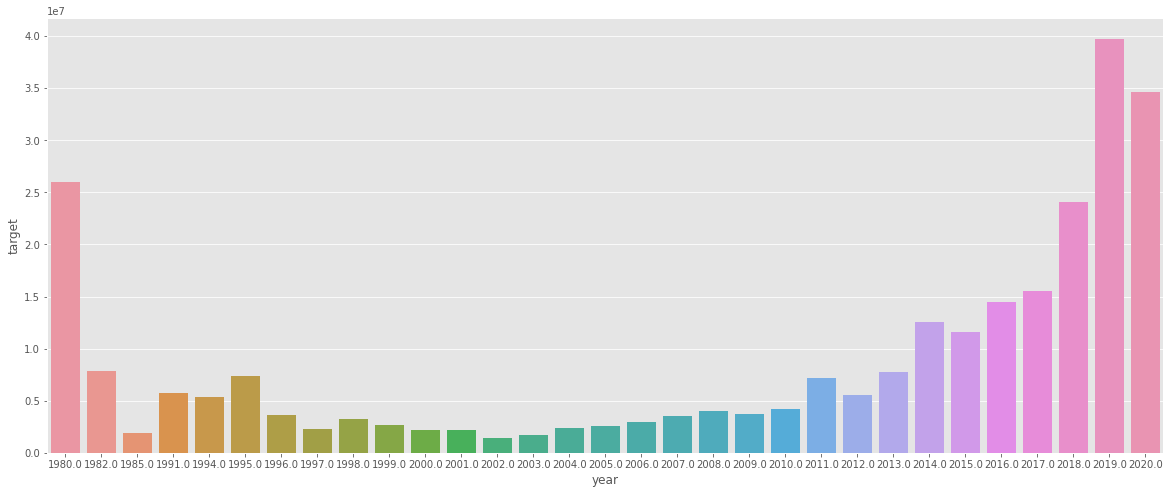

In [73]:
_data = train_df.groupby('year')['target'].mean().reset_index()
sns.barplot(data=_data, x='year', y='target');

In [74]:
train_df[train_df['year'] <= 1985.0]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year
100,100,volkswagen lt,161966.0,lagos,Locally used,6-cylinder(V6),manual,petrol,orange,1985.0,1915000,volkswagen,lt,6,0,V,4499.055556
608,608,mack r-686st,NaN,lagos,Locally used,6-cylinder(V6),manual,diesel,red,1982.0,7815000,mack,r-686st,6,0,V,NaN
1009,1009,man bockmann,809456.0,lagos,Locally used,6-cylinder(V6),manual,diesel,white,1980.0,26015000,man,bockmann,6,0,V,19742.829268


In [75]:
test_df[test_df['year'] <= 1985.0]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_8~,engine_d,odometer_per_year


test데이터에 1985년 이전 데이터도 없고 이상치인 듯 하니 608, 1009, 100 행 제거<br>
엔진이 H인 데이터가 없으니 H인 데이터 삭제<br>

In [76]:
# 엔진 
train_df.drop(train_df[train_df['engine_d'] == 'H'].id.values, axis=0, inplace=True)
train_df.drop('engine_d', axis=1, inplace=True)
test_df.drop('engine_d', axis=1, inplace=True)

# 가격, year 이상치 benz/52
train_df.drop(827, axis=0, inplace=True)

# 1985년 이전 데이터
train_df.drop(train_df[train_df['year'] < 1985].id.values, axis=0, inplace=True)

# 연 평균 주행거리 4만이상인 데이터
train_df.drop(train_df[train_df['odometer_per_year'] > 40000].id.values, axis=0, inplace=True)

In [77]:
train_df.isna().sum()

id                    0
title                 0
odometer             20
location              0
isimported            0
engine                0
transmission          0
fuel                  0
paint                 0
year                  1
target                0
manufacturer          0
model_name            0
cylinder              0
engine_8~             0
odometer_per_year    21
dtype: int64

In [78]:
train_df[train_df['year'].isna()]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_8~,odometer_per_year
415,415,mercedes-benz atego,403461.0,lagos,Locally used,4-cylinder(I4),manual,diesel,white,NaN,6015000,mercedes-benz,atego,4,0,NaN


In [79]:
display(train_df[(train_df['odometer'] >= 403461.0 - 40000) & (train_df['odometer'] <= 403461.0 + 40000)])
train_df.loc[(train_df['odometer'] >= 403461.0 - 40000) & (train_df['odometer'] <= 403461.0 + 40000), 'year'].mean()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,manufacturer,model_name,cylinder,engine_8~,odometer_per_year
189,189,lexus rx 330,366719.0,lagos,Locally used,4-cylinder(I4),automatic,petrol,Black,1999.0,1665000,lexus,rx 330,4,0,16669.045455
200,200,toyota sienna,424963.0,lagos,Locally used,6-cylinder(I6),automatic,petrol,Grey,1998.0,1170000,toyota,sienna,6,0,18476.652174
208,208,toyota highlander,382816.0,lagos,Locally used,6-cylinder(V6),automatic,petrol,Light Gold,2002.0,1775000,toyota,highlander,6,0,20148.210526
415,415,mercedes-benz atego,403461.0,lagos,Locally used,4-cylinder(I4),manual,diesel,white,NaN,6015000,mercedes-benz,atego,4,0,NaN


1999.6666666666667

year 결측치는 오차범위 4만(연 평균 주행거리 기준) odometer의 year 평균으로 채움<br>
odometer결측치는 연 평균 주행거리를 이용하여 계산

In [80]:
train_df.loc[train_df['year'].isna(), 'year'] = 2000

In [81]:
odometer_by_engine = train_df.groupby(['engine'])['odometer_per_year'].mean()
odometer_by_engine

engine
2-cylinder(I2)    10904.416667
3-cylinder(I3)    14570.901961
4-cylinder(I4)    10414.139289
5-cylinder(I5)    14755.966667
6-cylinder(I6)    10016.793875
6-cylinder(V6)    10846.316965
8-cylinder(V8)     8877.655011
Name: odometer_per_year, dtype: float64

In [82]:
na_rows = train_df[train_df['odometer'].isna()]
for i, engine in zip(na_rows.id.values, na_rows.engine.values):
    train_df.loc[train_df['id'] == i, 'odometer'] = odometer_by_engine[engine] * (2021 - na_rows.year)

In [83]:
na_rows = test_df[test_df['odometer'].isna()]
for i, engine in zip(na_rows.id.values, na_rows.engine.values):
    test_df.loc[test_df['id'] == i, 'odometer'] = odometer_by_engine[engine] * (2021 - na_rows.year)

In [84]:
train_df.isna().sum()

id                    0
title                 0
odometer              0
location              0
isimported            0
engine                0
transmission          0
fuel                  0
paint                 0
year                  0
target                0
manufacturer          0
model_name            0
cylinder              0
engine_8~             0
odometer_per_year    21
dtype: int64

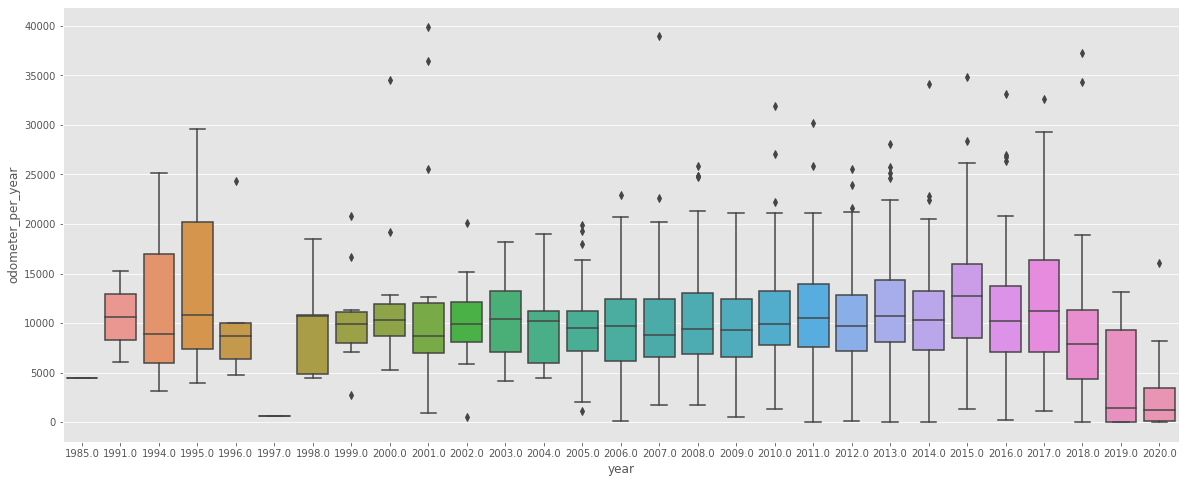

In [85]:
train_df['odometer_per_year'] = train_df['odometer'] / (2021 - train_df['year'])
sns.boxplot(data=train_df, x='year', y='odometer_per_year')
plt.show();

In [86]:
test_df[test_df['year'].isna()]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,manufacturer,model_name,cylinder,engine_8~,odometer_per_year
304,304,mercedes-benz cabin plus chassis only,650923.0,lagos,Locally used,6-cylinder(V6),manual,diesel,blue,NaN,mercedes-benz,cabin plus chassis only,6,0,NaN
406,406,mercedes-benz dump truck,NaN,lagos,Locally used,8-cylinder(V8),manual,diesel,white,NaN,mercedes-benz,dump truck,8,1,NaN
411,411,mercedes-benz water tanker,701934.0,lagos,Locally used,8-cylinder(V8),manual,diesel,white,NaN,mercedes-benz,water tanker,8,1,NaN


In [87]:
train_df[(train_df['odometer'] >= 650923 - 40000) & (train_df['odometer'] <= 650923 + 40000)].year.mean()

1994.0

In [88]:
train_df[(train_df['odometer'] >= 701934 - 40000) & (train_df['odometer'] <= 701934 + 40000)].year.mean()

1998.3333333333333

In [89]:
test_df.loc[test_df['id'] == 304, 'year'] = 1994
test_df.loc[test_df['id'] == 411, 'year'] = 1998

In [90]:
test_df.loc[test_df['id'] == 304, 'year'] = 2009
test_df.loc[test_df['id'] == 411, 'year'] = 2011
test_df.loc[test_df['id'] == 304, 'odometer'] = odometer_by_engine['6-cylinder(V6)'] * (2021 - 1994)
test_df.loc[test_df['id'] == 411, 'odometer'] = odometer_by_engine['8-cylinder(V8)'] * (2021 - 1998)

406의 경우 odometer와 year가 모두 결측치... 어쩔수 없이 year의 최다 빈도로 채워넣고 odometer예측

In [91]:
train_df[train_df['engine']=='8-cylinder(V8)'].year.mode()

0    2008.0
dtype: float64

In [92]:
test_df.loc[test_df['id'] == 406, 'year'] = 2008
test_df.loc[test_df['id'] == 406, 'odometer'] = odometer_by_engine['8-cylinder(V8)'] * (2021 - 2008)

In [93]:
test_df['odometer_per_year'] = test_df['odometer'] / (2021 - test_df['year'])

In [94]:
test_df.isna().sum()

id                   0
title                0
odometer             0
location             0
isimported           0
engine               0
transmission         0
fuel                 0
paint                0
year                 0
manufacturer         0
model_name           0
cylinder             0
engine_8~            0
odometer_per_year    0
dtype: int64

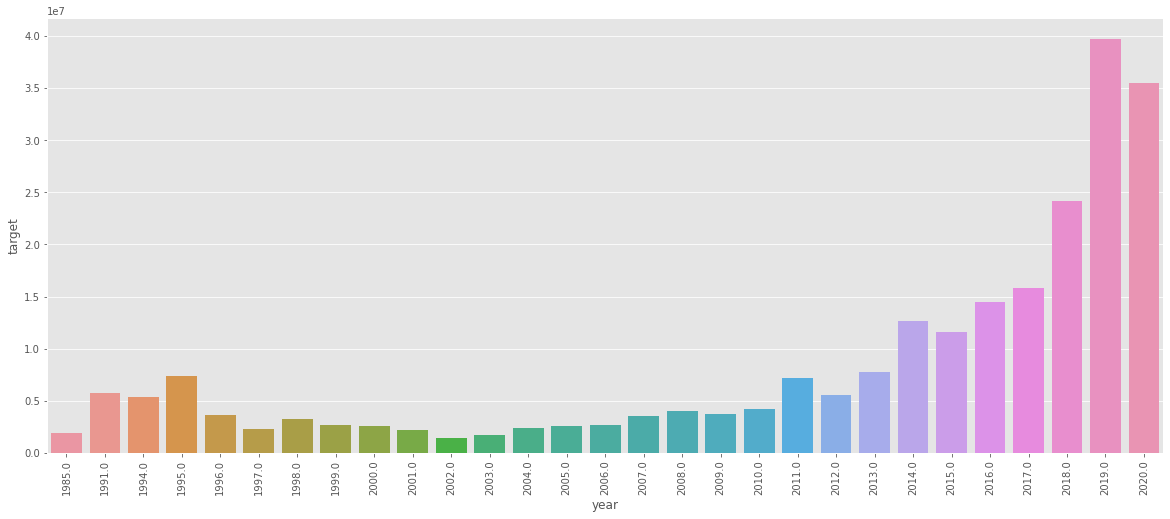

In [95]:
_data = train_df.groupby('year')['target'].mean().reset_index()
plt.xticks(rotation=90)
sns.barplot(data=_data, x='year', y='target');

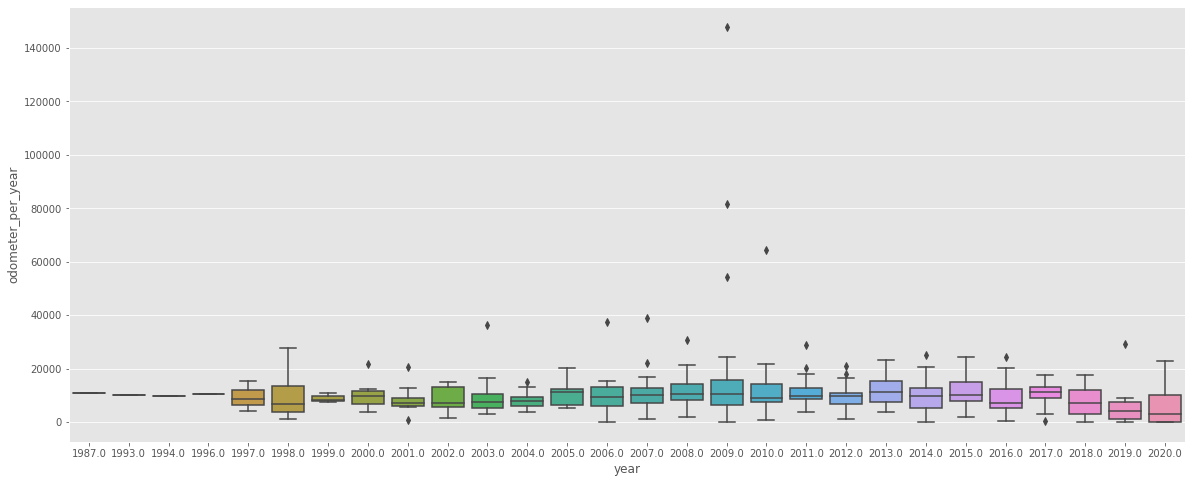

In [96]:
sns.boxplot(data=test_df, x='year', y='odometer_per_year')
plt.show();

In [97]:
train_df['year'] = train_df['year'].astype(int)
test_df['year'] = test_df['year'].astype(int)

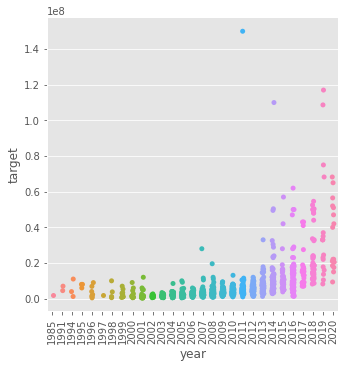

In [98]:
sns.catplot(data=train_df, x='year', y='target')
plt.xticks(rotation=90)
plt.show();

## transmission, fuel에 따른 가격
각 그룹에 유의한 차이가 없으므로 feature로 사용하지 않음

In [99]:
train_df['transmission'].value_counts()

automatic    957
manual        45
Name: transmission, dtype: int64

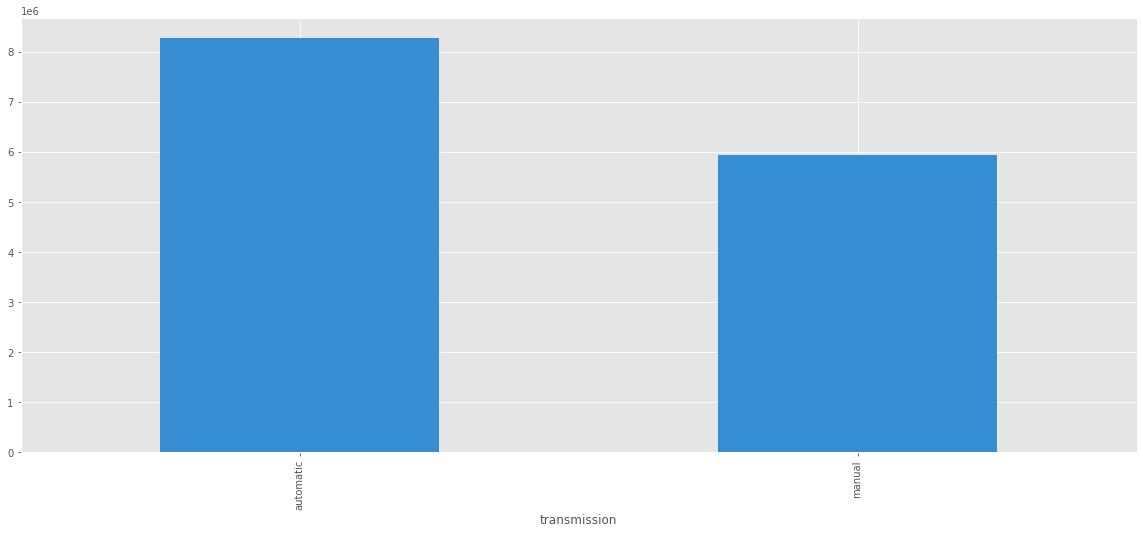

In [100]:
train_df.groupby(['transmission'])['target'].mean().plot(kind='bar');

In [101]:
print(clr.S + "정규성 검정" +clr.E)
print(kstest(train_df.loc[train_df['transmission'] == 'automatic', 'target'], 'norm'))
print(kstest(train_df.loc[train_df['transmission'] == 'manual', 'target'], 'norm'))

print(clr.S + "Levene Test" +clr.E)
print(levene(train_df.loc[train_df['transmission'] == 'automatic', 'target'], train_df.loc[train_df['transmission'] == 'manual', 'target']))

정규성 검정
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
Levene Test
LeveneResult(statistic=2.8471185057045783, pvalue=0.09184972121603507)


In [102]:
train_df['fuel'].value_counts()

petrol    962
diesel     40
Name: fuel, dtype: int64

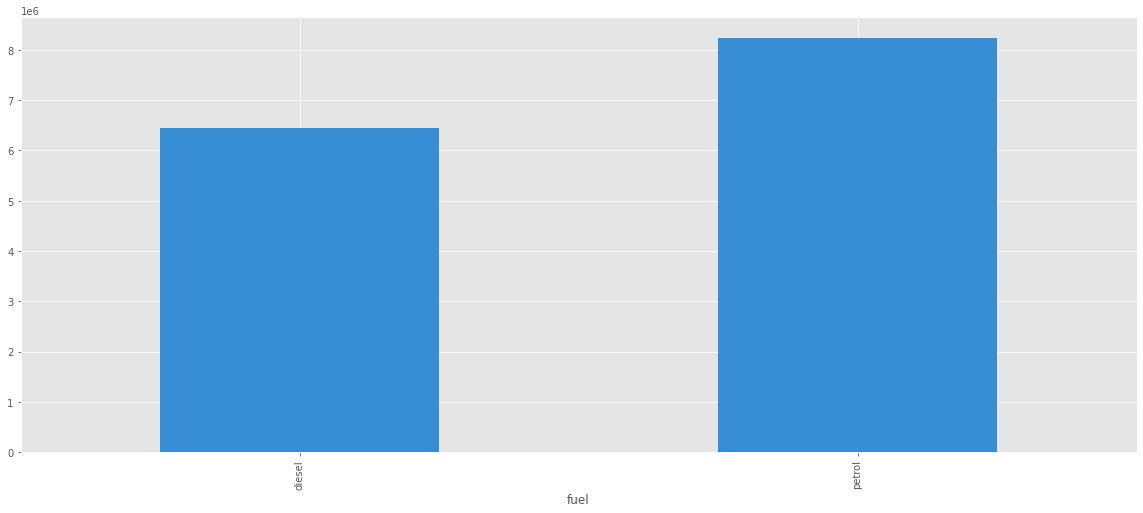

In [103]:
train_df.groupby(['fuel'])['target'].mean().plot(kind='bar');

In [104]:
print(clr.S + "정규성 검정" +clr.E)
print(kstest(train_df.loc[train_df['fuel'] == 'petrol', 'target'], 'norm'))
print(kstest(train_df.loc[train_df['fuel'] == 'diesel', 'target'], 'norm'))

print(clr.S + "Levene Test" +clr.E)
print(levene(train_df.loc[train_df['fuel'] == 'petrol', 'target'], train_df.loc[train_df['fuel'] == 'diesel', 'target']))

정규성 검정
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
Levene Test
LeveneResult(statistic=2.7142456061680615, pvalue=0.09977013495490043)


In [105]:
ttest_ind(train_df.loc[train_df['fuel'] == 'petrol', 'target'], train_df.loc[train_df['fuel'] == 'diesel', 'target'], equal_var = True)

Ttest_indResult(statistic=0.9072091659630873, pvalue=0.3645147528978062)

## 색상에 따른 가격 차이
색상 접두사 제거, 오타 교정 후 주요 색상이 포함되어있는 색상을 체크<br>

In [106]:
train_df['paint'] = train_df['paint'].str.strip()
train_df['paint'] = train_df['paint'].str.lower()
train_df['paint'] = train_df['paint'].str.strip('.')
train_df['paint'].value_counts()

black                     309
white                     140
silver                    108
grey                       86
blue                       78
red                        56
dark grey                  47
gold                       40
green                      20
gray                       17
dark blue                  17
brown                      16
wine                        9
sliver                      5
cream                       4
dark ash                    4
purple                      3
yellow                      3
ash                         3
white-blue                  2
dark gray                   2
sky blue                    2
maroon                      2
milk                        2
gery                        1
super white                 1
ash and black               1
off white                   1
magnetic gray metallic      1
skye blue                   1
black sand pearl            1
light silver                1
black and silver            1
whine     

In [107]:
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('dark ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('deep ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('light ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('sky ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('skye ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('navy ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('super ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('ink ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('midnight ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('magnetic ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('off ', ''))
train_df['paint'] = train_df['paint'].apply(lambda x: x.split('/')[0])
train_df['paint'] = train_df['paint'].apply(lambda x: x.split('-')[0])
train_df['paint'] = train_df['paint'].apply(lambda x: x.split()[0])

train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('sliver', 'silver'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('whine', 'wine'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('grey', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('ash', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('grey', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('gery', 'gray'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('white l', 'white'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('milk', 'white'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('beige', 'white'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('redl', 'red'))
train_df['paint'] = train_df['paint'].apply(lambda x: x.replace('yellow', 'gold'))

In [108]:
train_df['paint'].value_counts()

black     313
gray      163
white     149
silver    116
blue      102
red        57
gold       44
green      21
brown      16
wine       10
cream       4
purple      3
maroon      2
orange      1
pale        1
Name: paint, dtype: int64

In [109]:
print(clr.S + "정규성 검정" +clr.E)
black = train_df.loc[train_df['paint'] == 'black', 'target']
gray = train_df.loc[train_df['paint'] == 'gray', 'target']
white = train_df.loc[train_df['paint'] == 'white', 'target']
silver = train_df.loc[train_df['paint'] == 'silver', 'target']
blue = train_df.loc[train_df['paint'] == 'blue', 'target']
red = train_df.loc[train_df['paint'] == 'red', 'target']
gold = train_df.loc[train_df['paint'] == 'gold', 'target']
others = train_df.loc[(train_df['paint'] != 'black') & (train_df['paint'] != 'red') & (train_df['paint'] != 'gold')&(train_df['paint'] != 'blue')&(train_df['paint'] != 'silver')&(train_df['paint'] != 'white')&(train_df['paint'] != 'gray'), 'target']

print(kstest(black, 'norm'))
print(kstest(gray, 'norm'))
print(kstest(white, 'norm'))
print(kstest(silver, 'norm'))
print(kstest(blue, 'norm'))
print(kstest(red, 'norm'))
print(kstest(gold, 'norm'))
print(kstest(others, 'norm'))

정규성 검정
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


In [110]:
print(clr.S + "일원분산분석" +clr.E)
print(f_oneway(black, gray, white, silver, blue, red, gold, others))

일원분산분석
F_onewayResult(statistic=6.581770838909397, pvalue=1.2793032058285124e-07)


In [111]:
# 사후분석
print(clr.S + "p-value가 0에 수렴하므로 유의한 차이 존재" +clr.E)
Group = ["black"] * len(black) + ["gray"] * len(gray) + ["white"] * len(white) + ["silver"] * len(silver) + ["blue"] * len(blue) + ["red"] * len(red) + ["gold"] * len(gold) + ["others"] * len(others)
Data = black.tolist() + gray.tolist() + white.tolist() + silver.tolist() + blue.tolist() + red.tolist() + gold.tolist() + others.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

p-value가 0에 수렴하므로 유의한 차이 존재


group1,group2,meandiff,p-adj,lower,upper,reject
black,blue,-3991852.4969,0.0722,-8160000.3169,176295.3231,False
black,gold,-6726711.918,0.0126,-12612802.2095,-840621.6265,True
black,gray,-4774109.083,0.0011,-8305362.0019,-1242856.164,True
black,others,-6292079.6774,0.0065,-11518352.8724,-1065806.4825,True
black,red,-6091278.7095,0.0108,-11356087.273,-826470.146,True
black,silver,-6778471.9188,0.001,-10752389.0045,-2804554.8331,True
black,white,-3193238.2055,0.1341,-6831944.5128,445468.1017,False
blue,gold,-2734859.4211,0.9,-9328743.7217,3859024.8795,False
blue,gray,-782256.5861,0.9,-5397773.7215,3833260.5494,False
blue,others,-2300227.1805,0.9,-8312479.8996,3712025.5385,False


In [112]:
BW = train_df.loc[(train_df['paint'] == 'black') | (train_df['paint'] == 'white'), 'target']
GS = train_df.loc[(train_df['paint'] == 'gray') | (train_df['paint'] == 'silver'), 'target']
others = train_df.loc[(train_df['paint'] != 'black') & (train_df['paint'] != 'white')&(train_df['paint'] != 'silver')&(train_df['paint'] != 'gray'), 'target']

Group = ["BW"] * len(BW) + ["GS"] * len(GS) + ["others"] * len(others)
Data = BW.tolist() + GS.tolist() + others.tolist()
result = pairwise_tukeyhsd(Data, Group)
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
BW,GS,-4577610.3604,0.001,-6726594.3461,-2428626.3746,True
BW,others,-4392704.69,0.001,-6587404.2257,-2198005.1543,True
GS,others,184905.6704,0.9,-2255835.2881,2625646.6288,False


In [113]:
print(clr.S + "Levene Test" +clr.E)
print(levene(BW, train_df.loc[(train_df['paint'] != 'black') & (train_df['paint'] != 'white'), 'target']))

Levene Test
LeveneResult(statistic=25.357824776198406, pvalue=5.646987475198692e-07)


In [114]:
print(levene(train_df.loc[(train_df['paint'] == 'black'), 'target'], train_df.loc[(train_df['paint'] == 'white'), 'target']))

LeveneResult(statistic=6.087080255077929, pvalue=0.013980568947458092)


In [115]:
ttest_ind(train_df.loc[(train_df['paint'] == 'black'), 'target'], train_df.loc[(train_df['paint'] == 'white'), 'target'], equal_var = False)

Ttest_indResult(statistic=2.6596264491239, pvalue=0.008096764153640119)

black, white and others

In [116]:
# colors = {i:c for i, c in enumerate(['white', 'black', 'gray', 'silver', 'blue', 'red'])}
# def what_color(x, color):
#     c = colors[color]
#     if x.count(c):
#         return True
#     else:
#         return False

In [117]:
# train_df['paint'].apply(lambda x: what_color(x, 0)).value_counts()

In [118]:
test_df['paint'] = test_df['paint'].str.strip()
test_df['paint'] = test_df['paint'].str.lower()
test_df['paint'] = test_df['paint'].str.strip('.')
test_df['paint'].value_counts()

black                      124
silver                      63
white                       61
red                         36
grey                        32
blue                        31
dark grey                   14
gray                        13
green                       12
gold                        11
brown                        6
dark blue                    5
yellow                       3
dark green                   3
sliver                       3
cream                        2
light grey                   2
wine                         2
ash                          2
navy blue                    1
beige                        1
classic silver met(1f7)      1
grey and black               1
indigo ink pearl             1
white and green              1
golf                         1
dark ash                     1
blac                         1
maroon                       1
mint green                   1
Name: paint, dtype: int64

In [119]:
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('dark ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('deep ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('light ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('sky ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('classic ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('mint ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('navy ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('midnight ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('off ', ''))
test_df['paint'] = test_df['paint'].apply(lambda x: x.split('and')[0])
test_df['paint'] = test_df['paint'].apply(lambda x: x.split('/')[0])
test_df['paint'] = test_df['paint'].apply(lambda x: x.split('-')[0])
test_df['paint'] = test_df['paint'].apply(lambda x: x.split()[0])
test_df['paint'] = test_df['paint'].apply(lambda x: x.strip())

test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('grey', 'gray'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('ash', 'gray'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('yellow', 'gold'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('golf', 'gold'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('blac', 'black'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('sliver', 'silver'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('beige', 'white'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('cream', 'white'))
test_df['paint'] = test_df['paint'].apply(lambda x: x.replace('blackk', 'black'))

In [120]:
test_df['paint'].value_counts()

black     125
silver     67
white      65
gray       65
blue       37
red        36
green      16
gold       15
brown       6
wine        2
maroon      1
indigo      1
Name: paint, dtype: int64

## numerical data
### odometer 주행거리에 따른 가격
왜도와 첨도가 높음. 로그변환 수행필요<br>
중고차인데 주행거리가 0? <br>
주행거리와 가장 관련이 있는 year에 이상치가 동시에 존재하는 경우도 있음 ex. 2626.. (위에서 처리함)<br> 
이걸 어떻게 처리하느냐에 따라 점수가 달라질 것으로 보임

왜도 2.516770372835648
첨도 12.758464152585237


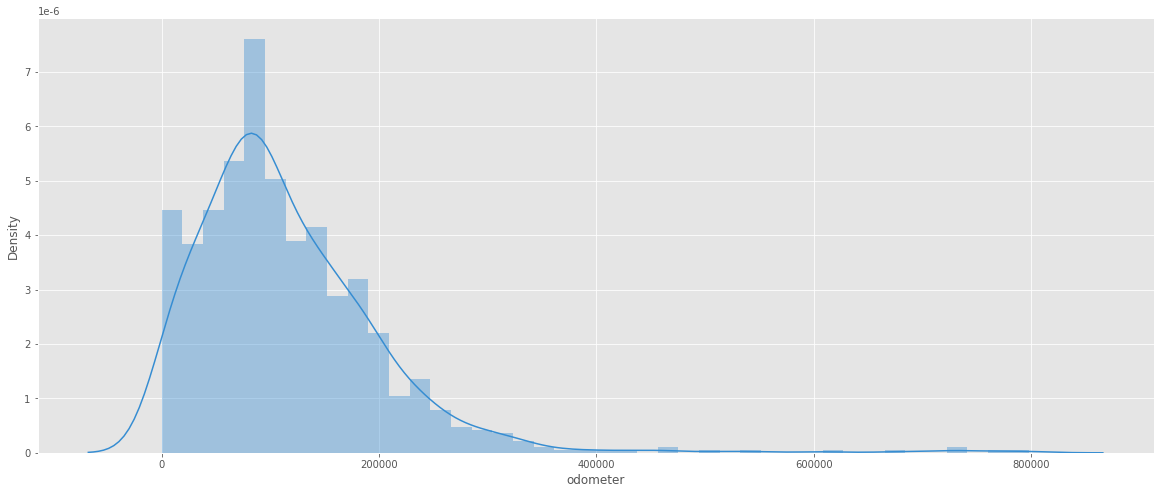

In [121]:
print(clr.S + "왜도"+clr.E, skew(train_df['odometer']))
print(clr.S + "첨도"+clr.E, kurtosis(train_df['odometer']))
sns.distplot(train_df['odometer'], kde=True);

왜도 6.043100671622574
첨도 61.24816250965999


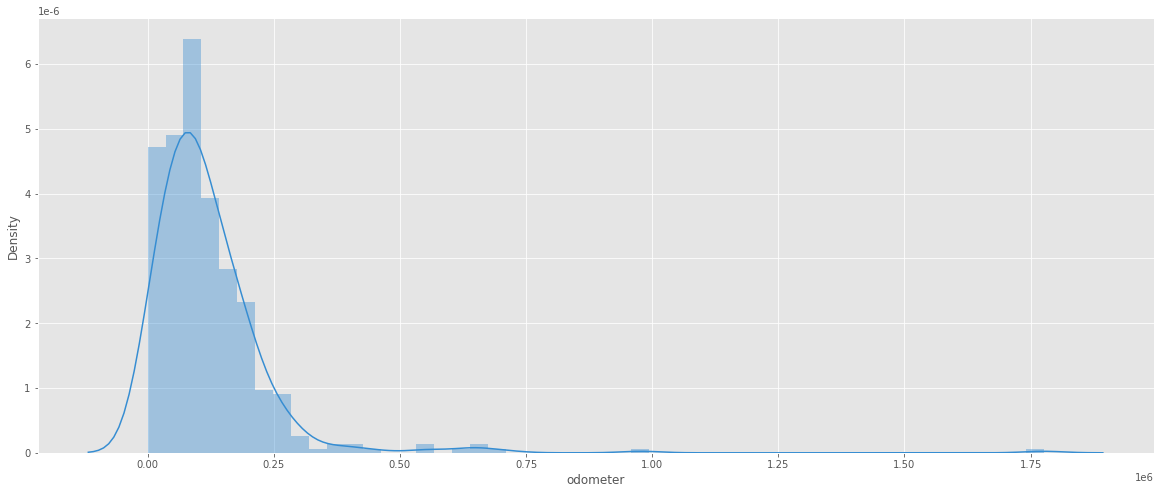

In [122]:
print(clr.S + "왜도"+clr.E, skew(test_df['odometer']))
print(clr.S + "첨도"+clr.E, kurtosis(test_df['odometer']))
sns.distplot(test_df['odometer'], kde=True);

## target 데이터 분포 확인

왜도 5.024197112577678
첨도 36.758574097181764


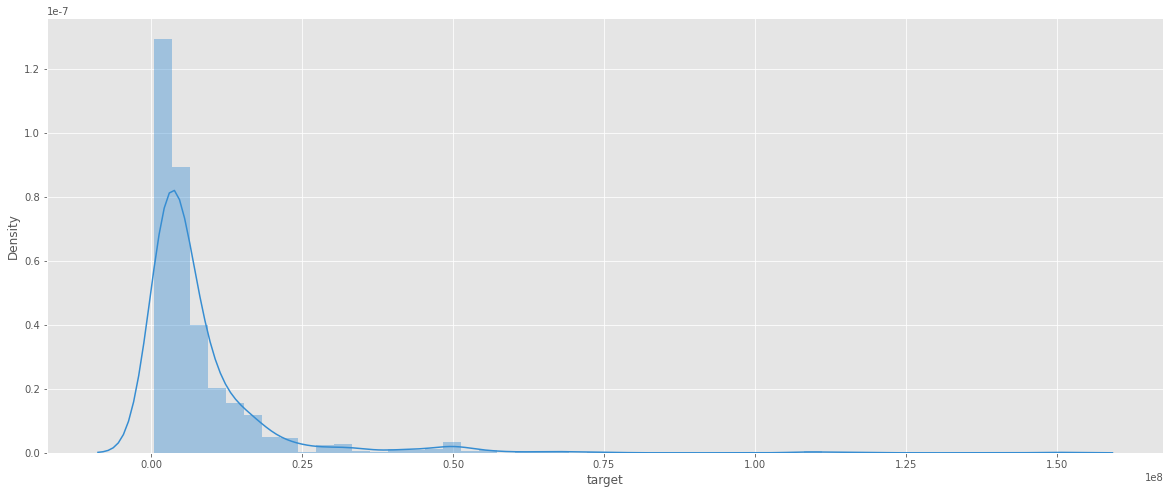

In [123]:
print(clr.S + "왜도"+clr.E, skew(train_df['target']))
print(clr.S + "첨도"+clr.E, kurtosis(train_df['target']))
sns.distplot(train_df['target'], kde=True);

### title 변수 파생 
- 전체 모델명으로 그루핑하는것은 훈련데이터에 없는 모델이 너무 많아서 부적절해보임<br>



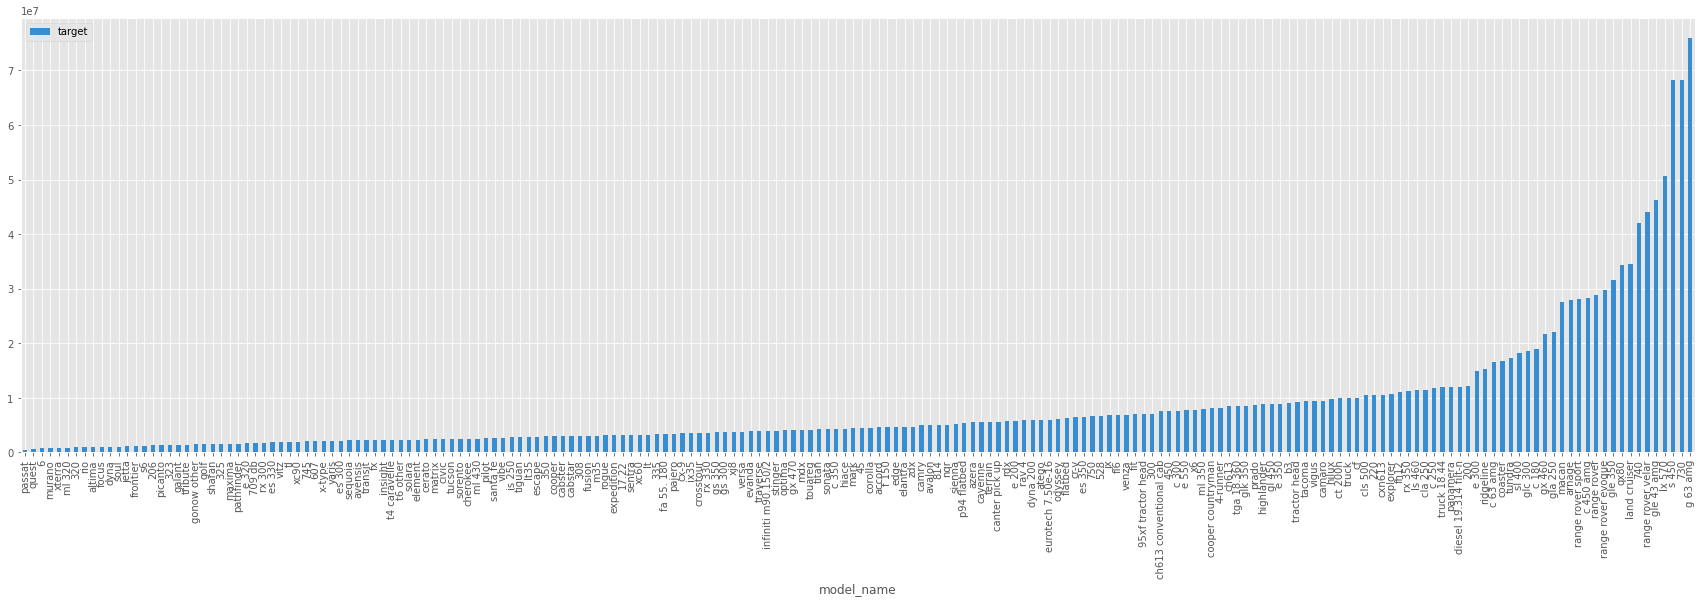

In [124]:
train_df[train_df['manufacturer'] != 'rolls-royce'].groupby('model_name')['target'].mean().reset_index().sort_values(by='target').set_index('model_name').plot(kind='bar', figsize=(30, 8));

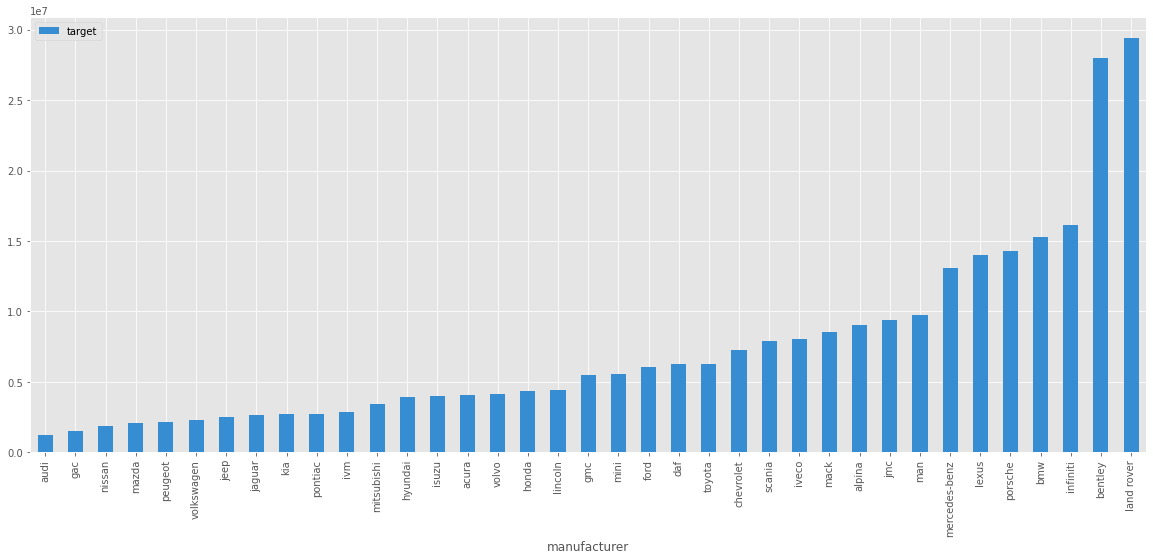

In [125]:
train_df[train_df['manufacturer'] != 'rolls-royce'].groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target').set_index('manufacturer').plot(kind='bar');

In [126]:
train_df.groupby('manufacturer')['target'].mean().reset_index().sort_values(by='target')['manufacturer'].values

array(['audi', 'gac', 'nissan', 'mazda', 'peugeot', 'volkswagen', 'jeep',
       'jaguar', 'kia', 'pontiac', 'ivm', 'mitsubishi', 'hyundai',
       'isuzu', 'acura', 'volvo', 'honda', 'lincoln', 'gmc', 'mini',
       'ford', 'daf', 'toyota', 'chevrolet', 'scania', 'iveco', 'mack',
       'alpina', 'jmc', 'man', 'mercedes-benz', 'lexus', 'porsche', 'bmw',
       'infiniti', 'bentley', 'land rover', 'rolls-royce'], dtype=object)

In [127]:
def cluster_manufacturer(x):
    if x in ['audi', 'gac', 'nissan', 'mazda', 'peugeot', 'volkswagen', 'jeep',
       'jaguar', 'kia', 'pontiac', 'ivm']:
       return 1
    elif x in ['mitsubishi', 'dodge', 'hyundai', 'isuzu', 'acura', 'volvo', 'honda', 'lincoln']:
       return 2
    elif x in ['gmc', 'mini', 'ford', 'daf', 'toyota']:
        return 3
    elif x in ['chevrolet', 'scania', 'iveco']:
        return 4
    elif x in ['alpina', 'mack', 'jmc', 'man']:
        return 5
    elif x in ['mercedes-benz', 'lexus', 'porsche', 'bmw', 'infiniti']:
        return 6
    elif x in ['bentley', 'land rover']:
        return 7
    elif x == 'rolls-royce':
        return 8
    else:
        return 0

In [128]:
train_df['cluster'] = train_df['manufacturer'].apply(lambda x: cluster_manufacturer(x))
train_df['cluster'].value_counts()

3    513
6    246
2    126
1     75
7     20
5     11
4     10
8      1
Name: cluster, dtype: int64

In [129]:
test_df['cluster'] = test_df['manufacturer'].apply(lambda x: cluster_manufacturer(x))
test_df['cluster'].value_counts()

3    238
6    102
2     58
1     21
7      6
5      5
4      4
0      1
8      1
Name: cluster, dtype: int64

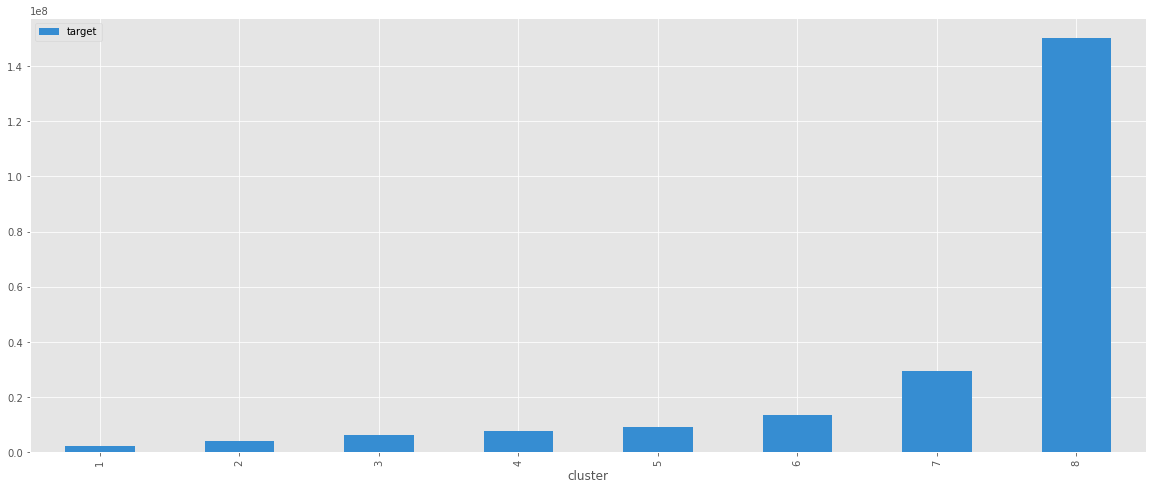

In [130]:
train_df.groupby('cluster')['target'].mean().reset_index().sort_values(by='target').set_index('cluster').plot(kind='bar');

In [131]:
print(train_df.isna().sum())
print(test_df.isna().sum())

id                   0
title                0
odometer             0
location             0
isimported           0
engine               0
transmission         0
fuel                 0
paint                0
year                 0
target               0
manufacturer         0
model_name           0
cylinder             0
engine_8~            0
odometer_per_year    0
cluster              0
dtype: int64
id                   0
title                0
odometer             0
location             0
isimported           0
engine               0
transmission         0
fuel                 0
paint                0
year                 0
manufacturer         0
model_name           0
cylinder             0
engine_8~            0
odometer_per_year    0
cluster              0
dtype: int64


In [132]:
train_df = train_df.reset_index(drop=True)

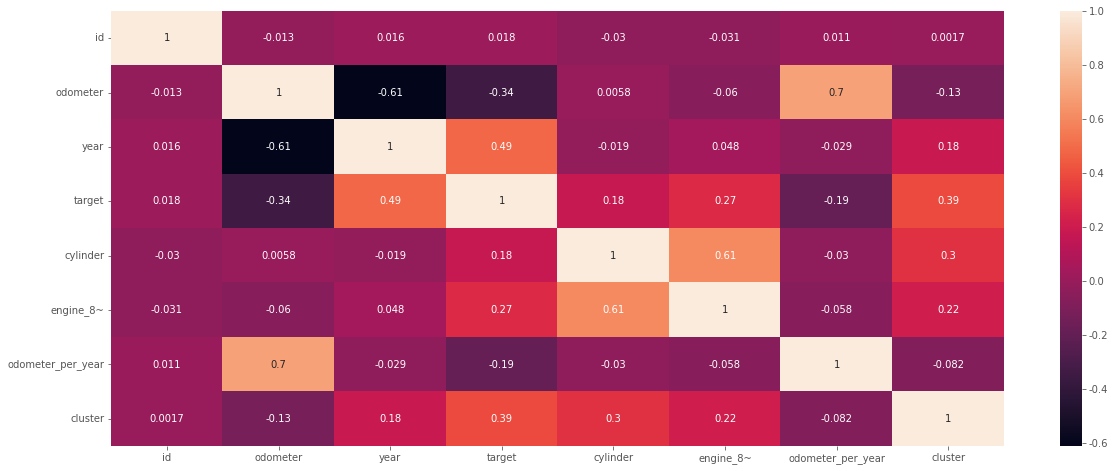

In [133]:
sns.heatmap(train_df.corr(), annot=True);

## 최종 feature

### categorical
- manufacturer : title에서 제조사 분리 <br>
- location : 판매처, [Ogun, other] <br>
- isimported : [Local, New] 원핫인코딩 <br>
- engine : ~~엔진 종류[I]만,~~ ~~실린더 8개이상인지 아닌지~~ <br>
- ~~transmission : 트랜스미션 종류.~~ <br>
- ~~fuel : 연료 종류~~ <br>
- paint : 페인트 색상 (6가지 주요색상으로 원핫인코딩)<br>

### numerical
- `odometer` : 주행 거리, 0(결측치) 처리, 로그변환 <br>
- `cylinder` : engine에서 실린더 수만 분리,
- `year` : 제조년도, <br> 
- `target` : 로그변환
- ~~`odometer_per_year` : 연간 평균 주행거리~~

In [134]:
print(train_df.columns)
print(test_df.columns)

Index(['id', 'title', 'odometer', 'location', 'isimported', 'engine',
       'transmission', 'fuel', 'paint', 'year', 'target', 'manufacturer',
       'model_name', 'cylinder', 'engine_8~', 'odometer_per_year', 'cluster'],
      dtype='object')
Index(['id', 'title', 'odometer', 'location', 'isimported', 'engine',
       'transmission', 'fuel', 'paint', 'year', 'manufacturer', 'model_name',
       'cylinder', 'engine_8~', 'odometer_per_year', 'cluster'],
      dtype='object')


In [179]:
train_X = train_df[['odometer', 'year', 'cylinder', 'engine_8~']]
test_X = test_df[['odometer', 'year', 'cylinder', 'engine_8~']]

# 로그변환
train_X['odometer'] = np.log1p(train_X['odometer'])
test_X['odometer'] = np.log1p(test_X['odometer'])

In [136]:
# from sklearn.preprocessing import MinMaxScaler
# mms = MinMaxScaler()
# train_X[['year', 'cylinder']] = mms.fit_transform(train_X[['year', 'cylinder']])
# test_X[['year', 'cylinder']] = mms.transform(test_X[['year', 'cylinder']])

In [180]:
train_X['location_ogun'] = (train_df['location'] == 'ogun').astype(int)
test_X['location_ogun'] = (test_df['location'] == 'ogun').astype(int)
train_X['location_other'] = ((train_df['location'] != 'ogun') & (train_df['location'] != 'lagos') & (train_df['location'] != 'abuja')).astype(int)
test_X['location_other'] = ((test_df['location'] != 'ogun') & (test_df['location'] != 'lagos') & (test_df['location'] != 'abuja')).astype(int)

train_X['isimported_New'] = (train_df['isimported'] == 'New').astype(int)
test_X['isimported_New'] = (test_df['isimported'] == 'New').astype(int)
train_X['isimported_Local'] = (train_df['isimported'] == 'Locally used').astype(int)
test_X['isimported_Local'] = (test_df['isimported'] == 'Locally used').astype(int)

In [181]:
for i in range(1, 9):
    train_X['manufacturer_' + str(i)] = (train_df['cluster'] == i).astype(int)
    test_X['manufacturer_' + str(i)] = (test_df['cluster'] == i).astype(int)

In [182]:
print(train_X.columns)
print(test_X.columns)

Index(['odometer', 'year', 'cylinder', 'engine_8~', 'location_ogun',
       'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8'],
      dtype='object')
Index(['odometer', 'year', 'cylinder', 'engine_8~', 'location_ogun',
       'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8'],
      dtype='object')


In [183]:
# 색상 원핫인코딩
train_X['color_black'] = (train_df['paint'] == 'black').astype(int)
test_X['color_black'] = (test_df['paint'] == 'black').astype(int)

train_X['color_white'] = (train_df['paint'] == 'white').astype(int)
test_X['color_white'] = (test_df['paint'] == 'white').astype(int)

In [184]:
train_X['target'] = np.log1p(train_df['target'])
# train_y = train_X.pop('target')

In [185]:
print(train_X.columns)
print(test_X.columns)

Index(['odometer', 'year', 'cylinder', 'engine_8~', 'location_ogun',
       'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8',
       'color_black', 'color_white', 'target'],
      dtype='object')
Index(['odometer', 'year', 'cylinder', 'engine_8~', 'location_ogun',
       'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8',
       'color_black', 'color_white'],
      dtype='object')


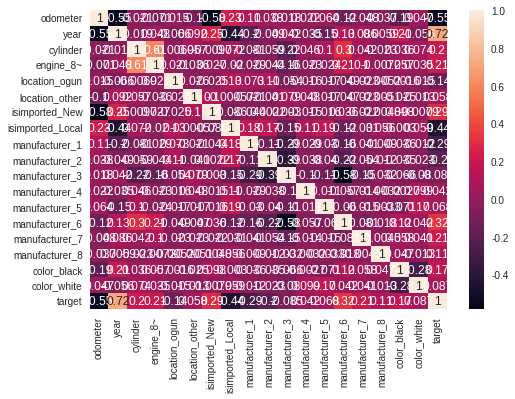

In [186]:
sns.heatmap(train_X.corr(), annot=True);

# Search model using Pycaret

In [144]:
from pycaret.regression import *

In [187]:
ignore_features = []
cat_features = ['engine_8~', 'location_ogun', 'location_other', 'isimported_New', 'isimported_Local',
       'manufacturer_1', 'manufacturer_2', 'manufacturer_3', 'manufacturer_4',
       'manufacturer_5', 'manufacturer_6', 'manufacturer_7', 'manufacturer_8',
       'color_black', 'color_white']
num_features = ['odometer', 'cylinder', 'year']

In [188]:
reg = setup(data=train_X,
            categorical_features=cat_features,
            numeric_features=num_features,
            ignore_features=ignore_features,
            target="target",
            # normalize=True,
            # normalize_method='minmax',
            train_size=.8,
            session_id=1,
            # profile=True
            )

,Description,Value
0,session_id,1
1,Target,target
2,Original Data,"(1002, 19)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,15
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(801, 18)"


In [189]:
best_models = compare_models(sort='mae', n_select=3, fold=10, verbose=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2948,0.1680,0.4066,0.8261,0.0250,0.0192,1.366
gbr,Gradient Boosting Regressor,0.2960,0.1713,0.4113,0.8226,0.0252,0.0193,0.081
rf,Random Forest Regressor,0.3145,0.2047,0.4505,0.7874,0.0276,0.0205,0.505
lightgbm,Light Gradient Boosting Machine,0.3217,0.1924,0.4370,0.8001,0.0267,0.0209,0.083
et,Extra Trees Regressor,0.3217,0.2219,0.4688,0.7669,0.0287,0.0210,0.456
knn,K Neighbors Regressor,0.3518,0.2537,0.5000,0.7382,0.0306,0.0229,0.060
lr,Linear Regression,0.3553,0.2486,0.4946,0.7420,0.0304,0.0231,0.303
lar,Least Angle Regression,0.3553,0.2486,0.4946,0.7420,0.0304,0.0231,0.016
ridge,Ridge Regression,0.3556,0.2475,0.4938,0.7433,0.0304,0.0231,0.012
br,Bayesian Ridge,0.3557,0.2480,0.4943,0.7428,0.0304,0.0231,0.013


In [190]:
tuned_top3 = [tune_model(model, fold=10, optimize='mae') for model in best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3456,0.2196,0.4686,0.7574,0.0289,0.0226
1,0.3524,0.2269,0.4764,0.7904,0.0295,0.0232
2,0.3002,0.1550,0.3937,0.8323,0.0235,0.0192
3,0.3782,0.2880,0.5366,0.7478,0.0333,0.0250
4,0.3499,0.2231,0.4723,0.7797,0.0289,0.0228
5,0.3720,0.2554,0.5053,0.7494,0.0305,0.0237
6,0.3234,0.1785,0.4225,0.7859,0.0258,0.0210
7,0.3041,0.1647,0.4058,0.7771,0.0245,0.0198
8,0.3232,0.1704,0.4128,0.8170,0.0259,0.0216


In [191]:
blended_models = blend_models(estimator_list=tuned_top3[:-1], fold=10, optimize='mae')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2808,0.1708,0.4133,0.8112,0.0255,0.0183
1,0.3075,0.1585,0.3981,0.8536,0.0244,0.0201
2,0.2612,0.1273,0.3568,0.8623,0.0219,0.0169
3,0.3219,0.2175,0.4664,0.8095,0.0291,0.0213
4,0.2826,0.1611,0.4013,0.8409,0.0246,0.0184
5,0.3508,0.2450,0.4949,0.7596,0.0302,0.0225
6,0.2924,0.1517,0.3895,0.8180,0.0241,0.0190
7,0.2592,0.1247,0.3531,0.8313,0.0213,0.0169
8,0.2685,0.1233,0.3512,0.8676,0.0220,0.0179


In [192]:
finalized_model = finalize_model(blended_models)
y_pred = predict_model(finalized_model, data=test_X)

In [155]:
y_pred = np.expm1(y_pred["Label"].values)

In [156]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = y_pred
sample_submission.head()

,id,target
0,0,2.086867e+07
1,1,5.013722e+06
2,2,6.097886e+06
3,3,1.345297e+06
4,4,2.661231e+06


In [157]:
sample_submission.to_csv('submission(pycaret).csv', index=False)

# CATBOOST

In [158]:
target = 'target'
train_y = train_X.pop('target')

In [159]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split

def MAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    return mae

In [161]:
SEED = 1
is_holdout = False
n_splits = 10
iterations = 3000
patience = 100

cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

In [162]:
scores = []
models = []
for tri, vai in cv.split(train_X):
    print("="*50)
    preds = []

    model = CatBoostRegressor(iterations=iterations, random_state=SEED, task_type="CPU", eval_metric="MAE", cat_features=cat_features)#,one_hot_max_size=4
    model.fit(train_X.iloc[tri], train_y[tri], 
            eval_set=[(train_X.iloc[vai], train_y[vai])], 
            early_stopping_rounds=patience,
            verbose = 100
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["MAE"])
    if is_holdout:
        break

Learning rate set to 0.02563
0:	learn: 0.7472136	test: 0.7884271	best: 0.7884271 (0)	total: 1.02ms	remaining: 3.05s
100:	learn: 0.3231071	test: 0.3414742	best: 0.3414742 (100)	total: 74.8ms	remaining: 2.15s
200:	learn: 0.2778037	test: 0.3167170	best: 0.3166357 (198)	total: 147ms	remaining: 2.04s
300:	learn: 0.2601462	test: 0.3130668	best: 0.3117562 (278)	total: 226ms	remaining: 2.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3117561515
bestIteration = 278

Shrink model to first 279 iterations.
Learning rate set to 0.02563
0:	learn: 0.7646724	test: 0.6323752	best: 0.6323752 (0)	total: 877us	remaining: 2.63s
100:	learn: 0.3212153	test: 0.3231220	best: 0.3231220 (100)	total: 93ms	remaining: 2.67s
200:	learn: 0.2719374	test: 0.3061997	best: 0.3049869 (142)	total: 172ms	remaining: 2.39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3049868649
bestIteration = 142

Shrink model to first 143 iterations.
Learning rate set to 0.025634
0:	learn: 0

In [163]:
print(scores)
print(np.mean(scores))

[0.3117561515458899, 0.30498686492439214, 0.29351131760631305, 0.2813347166296525, 0.3010263563186385, 0.28595003319808676, 0.34899250416710115, 0.2723157754886364, 0.2605120958185255, 0.2838285417821862]
0.29442143574794216


In [164]:
y_pred = model.predict(test_X)
y_pred = np.expm1(y_pred)
sample_submission["target"] = y_pred
sample_submission.head()

,id,target
0,0,2.011695e+07
1,1,5.813491e+06
2,2,6.265132e+06
3,3,1.425726e+06
4,4,2.541404e+06


In [ ]:
sample_submission.to_csv("submission(catboost).csv", index=False)

# CATBOOST + Optuna
reference : https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna 
<br>
docs : https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html
<br>
`'rsm'` `Random subspace method.` The percentage of features to use at each split selection, when features are selected over again at random. *This parameter can only be used with the cpu (that's why I will use CPU instead of GPU)

`'loss_funcion' : 'MAE'` is not implemented for GPU <br>
`'subsample' : ~ ` occur catboost error


In [166]:
import optuna

def objective(trial, data=train_X, target=train_y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=1)
    param = {
        'loss_function': 'MAE',
        #'task_type': 'GPU',    # MAE is not implemented for GPU
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
        #'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),      # occur catboost error
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':  25000,
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15]),
        'random_state': trial.suggest_categorical('random_state', [1]),
        # 'random_state': trial.suggest_int('random_state', 1, 42),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    model = CatBoostRegressor(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x, test_y)],early_stopping_rounds=200,verbose=False)
    preds = model.predict(test_x)
    mae = MAE(test_y, preds)

    return mae

In [167]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-06-10 01:17:33,130] A new study created in memory with name: no-name-2478b884-9be2-4a75-8943-47c3f740bdca
[I 2022-06-10 01:17:34,215] Trial 0 finished with value: 0.3173101414508951 and parameters: {'l2_leaf_reg': 3.460527243624728, 'max_bin': 235, 'rsm': 0.7152240849728694, 'learning_rate': 0.006363528710414287, 'max_depth': 7, 'random_state': 1, 'min_data_in_leaf': 211}. Best is trial 0 with value: 0.3173101414508951.
[I 2022-06-10 01:18:22,593] Trial 1 finished with value: 0.31652082912620355 and parameters: {'l2_leaf_reg': 3.126054150553235, 'max_bin': 359, 'rsm': 0.6435653882136426, 'learning_rate': 0.015839201003860923, 'max_depth': 15, 'random_state': 1, 'min_data_in_leaf': 205}. Best is trial 1 with value: 0.31652082912620355.
[I 2022-06-10 01:18:46,443] Trial 2 finished with value: 0.3204032568945765 and parameters: {'l2_leaf_reg': 0.43045066491442924, 'max_bin': 383, 'rsm': 0.690091188842934, 'learning_rate': 0.009826125237512418, 'max_depth': 13, 'random_state': 1, '

Number of finished trials: 50
Best trial: {'l2_leaf_reg': 0.51516988828254, 'max_bin': 354, 'rsm': 0.3918267173868489, 'learning_rate': 0.014780967306232887, 'max_depth': 13, 'random_state': 1, 'min_data_in_leaf': 3}


In [ ]:
# study.trials_dataframe()

## Visualization for Hyperparameter Optimization Analysis

In [168]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [169]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [170]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [171]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [172]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

# Train Catboost with Best parameters

In [173]:
Best_trial = study.best_trial.params

In [176]:
preds = np.zeros(test_X.shape[0])
kf = KFold(n_splits=5, random_state=1, shuffle=True)
scores = []   # list contains score for each fold
n = 0
for trn_idx, test_idx in kf.split(train_X, train_y):
    X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[test_idx]
    y_tr, y_val = train_y[trn_idx], train_y[test_idx]
    model = CatBoostRegressor(**Best_trial)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=150, verbose=False)
    preds += model.predict(test_X) / kf.n_splits
    scores.append(MAE(y_val, model.predict(X_val)))
    print(clr.S + "fold " + clr.E + f"{n+1}" + clr.S + " ==>  mae: " + clr.E + f"{scores[n]}")
    n += 1

fold 1 ==>  mae: 0.30635265353954355
fold 2 ==>  mae: 0.30602560657048605
fold 3 ==>  mae: 0.3133594832500354
fold 4 ==>  mae: 0.3131837998349772
fold 5 ==>  mae: 0.28452990595547684


In [177]:
print(clr.S + "mean mae: " + clr.E, np.mean(scores))

mean mae:  0.3046902898301038


In [178]:
y_pred = np.expm1(preds)
sample_submission["target"] = y_pred
sample_submission.head()

,id,target
0,0,1.887717e+07
1,1,5.588706e+06
2,2,6.402724e+06
3,3,1.538427e+06
4,4,2.585758e+06


In [ ]:
sample_submission.to_csv("submission(catboost+optuna).csv", index=False)